In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib.colors
#import matplotlib as mpl
#mpl.use('Agg')
from scipy.ndimage.filters import gaussian_filter
from scipy.special import erf
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import h5py
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
import glob, json
from scipy.special import erf
import sys
sys.path.append('./../')
from support import *

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [2]:
posteriors_w190814 = np.load("./../../input/sampleDict_w190814.pickle",allow_pickle=True)
posteriors = posteriors_w190814.copy()
posteriors.pop('S190814bv')
posteriors_no190412 = posteriors.copy()
posteriors_no190412.pop('S190412m')
posteriors_no190517 = posteriors.copy()
posteriors_no190517.pop('S190517h')
posteriors_no190412_no190517 = posteriors_no190412.copy()
posteriors_no190412_no190517.pop('S190517h')

samps_no_evol = np.load('../output/processed_emcee_samples_plPeak_noEvol_r00.npy')
samps = np.load('./../output/processed_emcee_samples_plPeak_r00.npy')
samps_no190412 = np.load('./../output/processed_emcee_samples_plPeak_no190412_r00.npy')
samps_no_evol_no190412 = np.load('../output/processed_emcee_samples_plPeak_noEvol_no190412_r00.npy')
samps_no190412_no190517 = np.load('./../output/processed_emcee_samples_plPeak_no190412_no190517_r00.npy')
samps_no190517 = np.load('./../output/processed_emcee_samples_plPeak_no190517_r00.npy')
samps_w190814 = np.load('./../output/processed_emcee_samples_plPeak_w190814_r00.npy')
samps_gaussianQ = np.load('./../output/processed_emcee_samples_plPeak_gaussianQ_r00.npy')
samps_bivariateGaussian = np.load('./../output/processed_emcee_samples_plPeak_bivariateGaussian_r05.npy')

n_catalogs = 750

# Initial Scatter

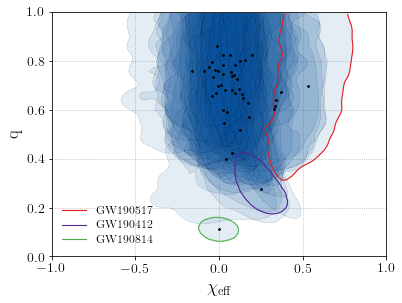

In [3]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i,key in enumerate(list(posteriors_w190814.keys())):
    
    chis = posteriors_w190814[key]['Xeff']
    m1s = posteriors_w190814[key]['m1']
    m2s = posteriors_w190814[key]['m2']
    qs = m2s/m1s
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    if key=='S190517h':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif key=='S190412m':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    elif key=='S190814bv':
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#4daf4a',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.1)
 

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1),
                Line2D([0], [0], color='#4daf4a', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412', 'GW190814'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

"""ax.text(0.94,0.08, '(a)', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,fontsize=15)"""

plt.savefig('./scatter.pdf',bbox_inches='tight')

# Reweighting and mock catalog generation

In [3]:
# Load mock detections
ref_m_min = 2.
ref_m_max = 100.
ref_a1 = -2.35
ref_a2 = 2.

mMin = 5.

mockDetections = h5py.File('/home/thomas.callister/RedshiftDistributions/spin-evolution/input/o3a_bbhpop_inj_info.hdf','r')
ifar_1 = mockDetections['injections']['ifar_gstlal'].value
ifar_2 = mockDetections['injections']['ifar_pycbc_bbh'].value
ifar_3 = mockDetections['injections']['ifar_pycbc_full'].value
detected = (ifar_1>1) + (ifar_2>1) + (ifar_3>1)
m1_det = mockDetections['injections']['mass1_source'].value[detected]
m2_det = mockDetections['injections']['mass2_source'].value[detected]
s1z_det = mockDetections['injections']['spin1z'].value[detected]
s2z_det = mockDetections['injections']['spin2z'].value[detected]
z_det = mockDetections['injections']['redshift'].value[detected]

mockDetectionsO1O2 = h5py.File('/home/thomas.callister/RedshiftDistributions/spin-evolution/input/injections_O1O2an_spin.h5','r')
m1_det = np.append(m1_det,mockDetectionsO1O2['mass1_source'])
m2_det = np.append(m2_det,mockDetectionsO1O2['mass2_source'])
s1z_det = np.append(s1z_det,mockDetectionsO1O2['spin1z'])
s2z_det = np.append(s2z_det,mockDetectionsO1O2['spin2z'])
z_det = np.append(z_det,mockDetectionsO1O2['redshift'])

# Derived quantities
q_det = m2_det/m1_det
X_det = (m1_det*s1z_det + m2_det*s2z_det)/(m1_det+m2_det)

ref_p_z = np.power(1.+z_det,2.-1.)
ref_p_m1 = np.power(m1_det,ref_a1)
ref_p_m2 = (1.+ref_a2)*np.power(m2_det,ref_a2)/(m1_det**(1.+ref_a2) - ref_m_min**(1.+ref_a2))

ref_p_xeff = np.zeros(X_det.size)
for i in range(ref_p_xeff.size):

    X = X_det[i]
    q = q_det[i]
    
    if X<-(1.-q)/(1.+q):
        ref_p_xeff[i] = (1./(2.*q))*(1.+q)*(1.+X)*(1.+q)/2.
        
    elif X>(1.-q)/(1.+q):
        ref_p_xeff[i] = (1./(2.*q))*(1.+q)*(1.-X)*(1.+q)/2.
        
    else:
        ref_p_xeff[i] = (1.+q)/2.

pop_reweight = 1./(ref_p_xeff*ref_p_m1*ref_p_m2*ref_p_z)
pop_reweight[m1_det<mMin] = 0.
pop_reweight[m2_det<mMin] = 0.

<ipython-input-3-d73ef177b37d>:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_1 = mockDetections['injections']['ifar_gstlal'].value
<ipython-input-3-d73ef177b37d>:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_2 = mockDetections['injections']['ifar_pycbc_bbh'].value
<ipython-input-3-d73ef177b37d>:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_3 = mockDetections['injections']['ifar_pycbc_full'].value
<ipython-input-3-d73ef177b37d>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  m1_det = mockDetections['injections']['mass1_source'].value[detected]
<ipython-input-3-d73ef177b37d>:15: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  m2_det = mockDetections['injections']['mass2_source'].value[detected]
<ipython-input-3-d73ef177b37d>:16: H5pyDeprecationWarning: dataset.valu

In [4]:
def asym(x):
    return -np.exp(-x**2)/np.sqrt(np.pi)/x*(1.-1./(2.*x**2))

def calculate_Gaussian(x, mu, sigma2, low, high):
    a = (low-mu)/np.sqrt(2*sigma2)
    b = (high-mu)/np.sqrt(2*sigma2)
    norm = np.sqrt(sigma2*np.pi/2)*(-erf(a) + erf(b))

    # If difference in error functions produce zero, overwrite with asymptotic expansion
    norm = np.array(norm.reshape(-1))
    a = np.array(norm.reshape(-1))
    b = np.array(norm.reshape(-1))
    if np.any(norm==0):
        badInds = np.where(norm==0)
        norm[badInds] = (np.sqrt(sigma2*np.pi/2)*(-asym(a) + asym(b)))[badInds]

    # If differences remain zero, then our domain of interest (-1,1) is so many std. deviations
    # from the mean that our parametrization is unphysical. In this case, discount this hyperparameter.
    # This amounts to an additional condition in our hyperprior
    # NaNs occur when norm is infinitesimal, like 1e-322, such that 1/norm is set to inf and the exponential term is zero
    y = (1.0/norm)*np.exp((-1.0*(x-mu)*(x-mu))/(2.*sigma2))
    if np.any(norm==0) or np.any(y!=y):
        return np.zeros(x.size)

    else:
        return y

In [5]:
mock_q_noEvol = np.zeros((len(posteriors),n_catalogs))
mock_x_noEvol = np.zeros((len(posteriors),n_catalogs))

resampled_q_noEvol = np.zeros((len(posteriors),n_catalogs))
resampled_x_noEvol = np.zeros((len(posteriors),n_catalogs))

mu_chi = np.zeros(n_catalogs)
logsig_chi = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps_no_evol.shape[0]))
    
    mMin = 5.
    lmbda = samps_no_evol[samp,0]
    mMax = samps_no_evol[samp,1]
    m0 = samps_no_evol[samp,2]
    sigM = samps_no_evol[samp,3]
    fPeak = samps_no_evol[samp,4]
    bq = samps_no_evol[samp,5]
    kappa = samps_no_evol[samp,6]
    mu0 = samps_no_evol[samp,7]
    logsig0 = samps_no_evol[samp,8]
    
    mu_chi[i] = mu0
    logsig_chi[i] = logsig0
    
    p_det_m1_pl = (1.+lmbda)*m1_det**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
    p_det_m1_pl[m1_det>mMax] = 0
    p_det_m1_peak = np.exp(-0.5*(m1_det-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
    mock_p_m1 = fPeak*p_det_m1_peak + (1.-fPeak)*p_det_m1_pl
    
    mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    mock_p_m2[m2_det<mMin]=0
    
    mock_p_z = np.power(1.+z_det,kappa-1.)
    mock_p_chi = calculate_Gaussian(X_det, mu0, 10.**(2.*logsig0),-1.,1.)
    
    p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
    p_det /= np.sum(p_det)
    
    try:
        detected_injections = np.random.choice(np.arange(m1_det.size),size=len(posteriors),p=p_det,replace=True)
        
    except ValueError:
        print(samp)
        
    mock_q_noEvol[:,i] = q_det[detected_injections]
    mock_x_noEvol[:,i] = X_det[detected_injections]

    for ii,key in enumerate(posteriors):

        chis = posteriors[key]['Xeff']
        Xeff_prior = posteriors[key]['Xeff_priors']
        m1s = posteriors[key]['m1']
        m2s = posteriors[key]['m2']
        zs = posteriors[key]['z']
        weights = posteriors[key]['weights']
        qs = m2s/m1s

        p_Chi = calculate_Gaussian(chis, mu0, 10.**(2.*logsig0),-1.,1.)

        # p(m1)
        p_m1_pl = (1.+lmbda)*m1s**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
        p_m1_pl[m1s>mMax] = 0.
        p_m1_peak = np.exp(-0.5*(m1s-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
        p_m1 = fPeak*p_m1_peak + (1.-fPeak)*p_m1_pl
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q_noEvol[ii,i] = qs[chosenInd]
        resampled_x_noEvol[ii,i] = chis[chosenInd]

In [7]:
mock_q = np.zeros((len(posteriors),n_catalogs))
mock_x = np.zeros((len(posteriors),n_catalogs))

resampled_q = np.zeros((len(posteriors),n_catalogs))
resampled_x = np.zeros((len(posteriors),n_catalogs))

mu_chi_evol = np.zeros(n_catalogs)
logsig_chi_evol = np.zeros(n_catalogs)
alpha_evol = np.zeros(n_catalogs)
beta_evol = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps.shape[0]))
    
    mMin = 5.
    lmbda = samps[samp,0]
    mMax = samps[samp,1]
    m0 = samps[samp,2]
    sigM = samps[samp,3]
    fPeak = samps[samp,4]
    bq = samps[samp,5]
    kappa = samps[samp,6]
    mu0 = samps[samp,7]
    logsig0 = samps[samp,8]
    alpha = samps[samp,9]
    beta = samps[samp,10]
    
    mu_chi_evol[i] = mu0
    logsig_chi_evol[i] = logsig0    
    alpha_evol[i] = alpha
    beta_evol[i] = beta
    
    p_det_m1_pl = (1.+lmbda)*m1_det**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
    p_det_m1_pl[m1_det>mMax] = 0
    p_det_m1_peak = np.exp(-0.5*(m1_det-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
    mock_p_m1 = fPeak*p_det_m1_peak + (1.-fPeak)*p_det_m1_pl 
    
    mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    mock_p_m2[m2_det<mMin]=0
    
    mock_p_z = np.power(1.+z_det,kappa-1.)
    
    mu = mu0 + alpha*(q_det-0.5)
    logsig = logsig0 + beta*(q_det-0.5)
    mock_p_chi = calculate_Gaussian(X_det, mu, 10.**(2.*logsig),-1.,1.)
    
    p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
    p_det /= np.sum(p_det)
    detected_injections = np.random.choice(np.arange(m1_det.size),size=len(posteriors),p=p_det,replace=False)
    mock_q[:,i] = q_det[detected_injections]
    mock_x[:,i] = X_det[detected_injections]

    for ii,key in enumerate(posteriors):

        chis = posteriors[key]['Xeff']
        Xeff_prior = posteriors[key]['Xeff_priors']
        m1s = posteriors[key]['m1']
        m2s = posteriors[key]['m2']
        zs = posteriors[key]['z']
        weights = posteriors[key]['weights']
        qs = m2s/m1s
        
        mu = mu0 + alpha*(qs-0.5)
        logsig = logsig0 + beta*(qs-0.5)
        p_Chi = calculate_Gaussian(chis, mu, 10.**(2.*logsig),-1.,1.)

        # p(m1)
        p_m1_pl = (1.+lmbda)*m1s**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
        p_m1_pl[m1s>mMax] = 0.
        p_m1_peak = np.exp(-0.5*(m1s-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
        p_m1 = fPeak*p_m1_peak + (1.-fPeak)*p_m1_pl
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q[ii,i] = qs[chosenInd]
        resampled_x[ii,i] = chis[chosenInd]

In [5]:
mock_q_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))
mock_x_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))

resampled_q_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))
resampled_x_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))

mu_chi_evol_no190412 = np.zeros(n_catalogs)
logsig_chi_evol_no190412 = np.zeros(n_catalogs)
alpha_evol_no190412 = np.zeros(n_catalogs)
beta_evol_no190412 = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    success=False
    while success==False:
    
        samp = np.random.choice(np.arange(samps_no190412.shape[0]))

        mMin = 5.
        lmbda = samps_no190412[samp,0]
        mMax = samps_no190412[samp,1]
        m0 = samps_no190412[samp,2]
        sigM = samps_no190412[samp,3]
        fPeak = samps_no190412[samp,4]
        bq = samps_no190412[samp,5]
        kappa = samps_no190412[samp,6]
        mu0 = samps_no190412[samp,7]
        logsig0 = samps_no190412[samp,8]
        alpha = samps_no190412[samp,9]
        beta = samps_no190412[samp,10]

        mu_chi_evol_no190412[i] = mu0
        logsig_chi_evol_no190412[i] = logsig0    
        alpha_evol_no190412[i] = alpha
        beta_evol_no190412[i] = beta

        p_det_m1_pl = (1.+lmbda)*m1_det**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
        p_det_m1_pl[m1_det>mMax] = 0
        p_det_m1_peak = np.exp(-0.5*(m1_det-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
        mock_p_m1 = fPeak*p_det_m1_peak + (1.-fPeak)*p_det_m1_pl  

        mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
        mock_p_m2[m2_det<mMin]=0

        mock_p_z = np.power(1.+z_det,kappa-1.)

        mu = mu0 + alpha*(q_det-0.5)
        logsig = logsig0 + beta*(q_det-0.5)
        mock_p_chi = calculate_Gaussian(X_det, mu, 10.**(2.*logsig),-1.,1.)

        p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
        p_det /= np.sum(p_det)
        
        if np.all(np.isfinite(p_det)):
            detected_injections = np.random.choice(np.arange(m1_det.size),size=len(posteriors_no190412),p=p_det,replace=False)
            mock_q_no190412[:,i] = q_det[detected_injections]
            mock_x_no190412[:,i] = X_det[detected_injections]
            success=True
        else:
            print(samp)
            success=False

        for ii,key in enumerate(posteriors_no190412):

            chis = posteriors_no190412[key]['Xeff']
            Xeff_prior = posteriors_no190412[key]['Xeff_priors']
            m1s = posteriors_no190412[key]['m1']
            m2s = posteriors_no190412[key]['m2']
            zs = posteriors_no190412[key]['z']
            weights = posteriors_no190412[key]['weights']
            qs = m2s/m1s

            mu = mu0 + alpha*(qs-0.5)
            logsig = logsig0 + beta*(qs-0.5)
            p_Chi = calculate_Gaussian(chis, mu, 10.**(2.*logsig),-1.,1.)

            # p(m1)
            p_m1_pl = (1.+lmbda)*m1s**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
            p_m1_pl[m1s>mMax] = 0.
            p_m1_peak = np.exp(-0.5*(m1s-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
            p_m1 = fPeak*p_m1_peak + (1.-fPeak)*p_m1_pl
            old_m1_prior = np.ones(m1s.size)

            # p(m2)
            p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
            old_m2_prior = np.ones(m1s.size)
            p_m2[m2s<mMin]=0

            # p(z)
            p_z = np.power(1.+zs,kappa-1.)
            old_pz_prior = (1.+zs)**(2.7-1.)

            # Draw probs
            probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior

            if np.any(probs!=probs):
                print(np.where(probs!=probs))
                print(probs)
            probs[probs<0] = 0.
            probs /= np.sum(probs)

            if np.all(np.isfinite(probs)):
                chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
                resampled_q_no190412[ii,i] = qs[chosenInd]
                resampled_x_no190412[ii,i] = chis[chosenInd]
                success=True
            else:
                print(samp)
                success=False
            

<ipython-input-4-ccfa50e650bd>:2: RuntimeWarning: divide by zero encountered in true_divide
  return -np.exp(-x**2)/np.sqrt(np.pi)/x*(1.-1./(2.*x**2))
<ipython-input-4-ccfa50e650bd>:15: RuntimeWarning: invalid value encountered in add
  norm[badInds] = (np.sqrt(sigma2*np.pi/2)*(-asym(a) + asym(b)))[badInds]
<ipython-input-5-25640a095de1>:52: RuntimeWarning: invalid value encountered in true_divide
  p_det /= np.sum(p_det)
<ipython-input-5-25640a095de1>:100: RuntimeWarning: invalid value encountered in true_divide
  probs /= np.sum(probs)


461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
654
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
461
432
654
279
279
279
279
279
279
279
279
279
279
279
279
279
279
279
279
279
279
279
279
279
313
313
313
313
313
313
313
313
313
313
313
313
313
313
313
596
596
596
596
596
596
596
596
596
596
255
255
255
255
255
255
255
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
596
596
596
596
596
596
596
596
596
596
255
255
255
255
255
255
255
747
747
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358
358


In [8]:
mock_q_w190814 = np.zeros((len(posteriors_w190814),n_catalogs))
mock_x_w190814 = np.zeros((len(posteriors_w190814),n_catalogs))

resampled_q_w190814 = np.zeros((len(posteriors_w190814),n_catalogs))
resampled_x_w190814 = np.zeros((len(posteriors_w190814),n_catalogs))

mu_chi_evol_w190814 = np.zeros(n_catalogs)
logsig_chi_evol_w190814 = np.zeros(n_catalogs)
alpha_evol_w190814 = np.zeros(n_catalogs)
beta_evol_w190814 = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps_w190814.shape[0]))
    
    mMin = 2.5
    lmbda = samps_w190814[samp,0]
    mMax = samps_w190814[samp,1]
    m0 = samps_w190814[samp,2]
    sigM = samps_w190814[samp,3]
    fPeak = samps_w190814[samp,4]
    bq = samps_w190814[samp,5]
    kappa = samps_w190814[samp,6]
    mu0 = samps_w190814[samp,7]
    logsig0 = samps_w190814[samp,8]
    alpha = samps_w190814[samp,9]
    beta = samps_w190814[samp,10]
    
    mu_chi_evol_w190814[i] = mu0
    logsig_chi_evol_w190814[i] = logsig0    
    alpha_evol_w190814[i] = alpha
    beta_evol_w190814[i] = beta
    
    p_det_m1_pl = (1.+lmbda)*m1_det**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
    p_det_m1_pl[m1_det>mMax] = 0
    p_det_m1_peak = np.exp(-0.5*(m1_det-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
    mock_p_m1 = fPeak*p_det_m1_peak + (1.-fPeak)*p_det_m1_pl  
    
    mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    mock_p_m2[m2_det<mMin]=0
    
    mock_p_z = np.power(1.+z_det,kappa-1.)
    
    mu = mu0 + alpha*(q_det-0.5)
    logsig = logsig0 + beta*(q_det-0.5)
    mock_p_chi = calculate_Gaussian(X_det, mu, 10.**(2.*logsig),-1.,1.)
    
    p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
    p_det /= np.sum(p_det)
    detected_injections = np.random.choice(np.arange(m1_det.size),size=len(posteriors_w190814),p=p_det,replace=False)
    mock_q_w190814[:,i] = q_det[detected_injections]
    mock_x_w190814[:,i] = X_det[detected_injections]

    for ii,key in enumerate(posteriors_w190814):

        chis = posteriors_w190814[key]['Xeff']
        Xeff_prior = posteriors_w190814[key]['Xeff_priors']
        m1s = posteriors_w190814[key]['m1']
        m2s = posteriors_w190814[key]['m2']
        zs = posteriors_w190814[key]['z']
        weights = posteriors_w190814[key]['weights']
        qs = m2s/m1s
        
        mu = mu0 + alpha*(qs-0.5)
        logsig = logsig0 + beta*(qs-0.5)
        p_Chi = calculate_Gaussian(chis, mu, 10.**(2.*logsig),-1.,1.)

        # p(m1)
        p_m1_pl = (1.+lmbda)*m1s**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
        p_m1_pl[m1s>mMax] = 0.
        p_m1_peak = np.exp(-0.5*(m1s-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
        p_m1 = fPeak*p_m1_peak + (1.-fPeak)*p_m1_pl
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q_w190814[ii,i] = qs[chosenInd]
        resampled_x_w190814[ii,i] = chis[chosenInd]

In [13]:
resampled_q_gaussianQ = np.zeros((len(posteriors),n_catalogs))
resampled_x_gaussianQ = np.zeros((len(posteriors),n_catalogs))

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps_gaussianQ.shape[0]))
    
    mMin = 2.5
    lmbda = samps_gaussianQ[samp,0]
    mMax = samps_gaussianQ[samp,1]
    m0 = samps_gaussianQ[samp,2]
    sigM = samps_gaussianQ[samp,3]
    fPeak = samps_gaussianQ[samp,4]
    mu_q = samps_gaussianQ[samp,5]
    sig_q = samps_gaussianQ[samp,6]
    kappa = samps_gaussianQ[samp,7]
    mu0 = samps_gaussianQ[samp,8]
    logsig0 = samps_gaussianQ[samp,9]
    alpha = samps_gaussianQ[samp,10]
    beta = samps_gaussianQ[samp,11]

    for ii,key in enumerate(posteriors):

        chis = posteriors[key]['Xeff']
        Xeff_prior = posteriors[key]['Xeff_priors']
        m1s = posteriors[key]['m1']
        m2s = posteriors[key]['m2']
        zs = posteriors[key]['z']
        weights = posteriors[key]['weights']
        qs = m2s/m1s
        
        mu = mu0 + alpha*(qs-0.5)
        logsig = logsig0 + beta*(qs-0.5)
        p_Chi = calculate_Gaussian(chis, mu, 10.**(2.*logsig),-1.,1.)

        # p(m1)
        p_m1_pl = (1.+lmbda)*m1s**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
        p_m1_pl[m1s>mMax] = 0.
        p_m1_peak = np.exp(-0.5*(m1s-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
        p_m1 = fPeak*p_m1_peak + (1.-fPeak)*p_m1_pl
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        #p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        p_m2 = calculate_Gaussian(qs,mu_q,sig_q,mMin/m1s,1.)/m1s
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q_gaussianQ[ii,i] = qs[chosenInd]
        resampled_x_gaussianQ[ii,i] = chis[chosenInd]

In [21]:
resampled_q_bivariateGaussian = np.zeros((len(posteriors),400))
resampled_x_bivariateGaussian = np.zeros((len(posteriors),400))

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps_bivariateGaussian.shape[0]))
    
    mMin = 5.
    lmbda = samps_bivariateGaussian[samp,0]
    mMax = samps_bivariateGaussian[samp,1]
    m0 = samps_bivariateGaussian[samp,2]
    sigM = samps_bivariateGaussian[samp,3]
    fPeak = samps_bivariateGaussian[samp,4]
    f_lowSpin = samps_bivariateGaussian[samp,5]
    mu_q_lowSpin = samps_bivariateGaussian[samp,6]
    logsig_q_lowSpin = samps_bivariateGaussian[samp,7]
    mu_q_highSpin = samps_bivariateGaussian[samp,8]
    logsig_q_highSpin = samps_bivariateGaussian[samp,9]
    kappa = samps_bivariateGaussian[samp,10]
    mu_chi_lowSpin = samps_bivariateGaussian[samp,11]
    logsig_chi_lowSpin = samps_bivariateGaussian[samp,12]
    mu_chi_highSpin = samps_bivariateGaussian[samp,13]
    logsig_chi_highSpin = samps_bivariateGaussian[samp,14]

    for ii,key in enumerate(posteriors):

        chis = posteriors[key]['Xeff']
        Xeff_prior = posteriors[key]['Xeff_priors']
        m1s = posteriors[key]['m1']
        m2s = posteriors[key]['m2']
        zs = posteriors[key]['z']
        weights = posteriors[key]['weights']
        qs = m2s/m1s
        
        mu = mu0 + alpha*(qs-0.5)
        logsig = logsig0 + beta*(qs-0.5)
        p_Chi = calculate_Gaussian(chis, mu, 10.**(2.*logsig),-1.,1.)

        # p(m1)
        p_m1_pl = (1.+lmbda)*m1s**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
        p_m1_pl[m1s>mMax] = 0.
        p_m1_peak = np.exp(-0.5*(m1s-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
        p_m1 = fPeak*p_m1_peak + (1.-fPeak)*p_m1_pl
        old_m1_prior = np.ones(m1s.size)
        old_m1_prior = np.ones(m2s.size)

        # p(m2)
        p_Xeff_m2_lowSpin = calculate_Gaussian_2D(chis,qs,mu_chi_lowSpin,10.**(2.*logsig_chi_lowSpin),\
                    mu_q_lowSpin,10.**(2.*logsig_q_lowSpin),-1.,1.,0.,1.)/m1s
        p_Xeff_m2_highSpin = calculate_Gaussian_2D(chis,qs,mu_chi_highSpin,10.**(2.*logsig_chi_highSpin),\
                    mu_q_highSpin,10.**(2.*logsig_q_highSpin),-1.,1.,0.,1.)/m1s
        p_Xeff_m2 = f_lowSpin*p_Xeff_m2_lowSpin + (1.-f_lowSpin)*p_Xeff_m2_highSpin
        p_Xeff_m2[m2s<mMin] = 0.

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q_bivariateGaussian[ii,i] = qs[chosenInd]
        resampled_x_bivariateGaussian[ii,i] = chis[chosenInd]

IndexError: index 400 is out of bounds for axis 1 with size 400

# Blob plot, reweighted to non-evolving population

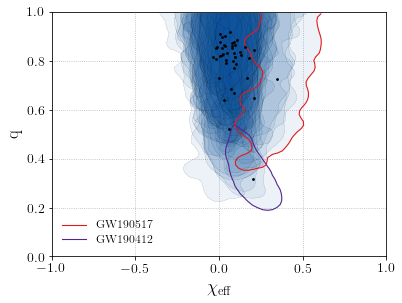

In [9]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(resampled_q_noEvol.shape[0]):
    
    chis = resampled_x_noEvol[i,:]
    qs = resampled_q_noEvol[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    i190517=np.where(np.array(list(posteriors.keys()))=='S190517h')[0][0]
    i190412=np.where(np.array(list(posteriors.keys()))=='S190412m')[0][0]
    
    if i==i190517:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif i==i190412:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)

    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)
 

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

"""ax.text(0.94,0.08, '(b)', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,fontsize=15)"""

plt.savefig('./reweighted_posterior_scatter_noEvolution.pdf',bbox_inches='tight')

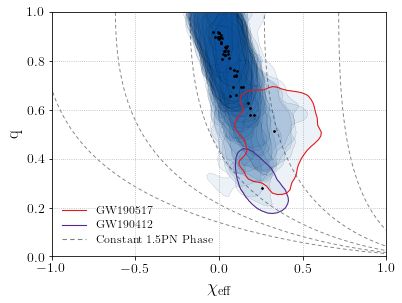

In [10]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(resampled_q.shape[0]):
    
    chis = resampled_x[i,:]
    qs = resampled_q[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    i190517=np.where(np.array(list(posteriors.keys()))=='S190517h')[0][0]
    i190412=np.where(np.array(list(posteriors.keys()))=='S190412m')[0][0]
    
    if i==i190517:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif i==i190412:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)
 
# See Ng+ Eq. A2
for dphase in np.linspace(-4.5,-1.5,5):
    qs = np.linspace(0.01,1,100)
    etas = qs/(1.+qs)**2
    chi_effs = (dphase*etas**(3./5.) + 3.*np.pi/8.)*128./(113.-76.*etas)
    ax.plot(chi_effs,qs,color='grey',dashes=(4,3),zorder=-1,lw=0.9)

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1),
                Line2D([0], [0], color='grey', lw=1.1,dashes=(4,3))]
ax.legend(custom_lines, ['GW190517', 'GW190412','Constant 1.5PN Phase'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

"""ax.text(0.94,0.08, ' (a)', horizontalalignment='right', 
        verticalalignment='center', transform=ax.transAxes,fontsize=15, backgroundcolor='white')"""

plt.savefig('./reweighted_posterior_scatter_yesEvolution.pdf',bbox_inches='tight')

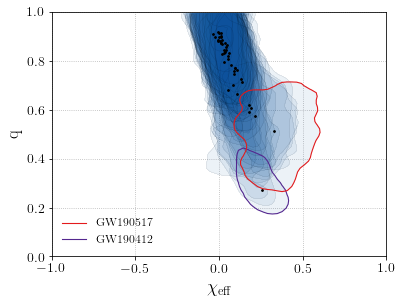

In [427]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(resampled_q.shape[0]):
    
    chis = resampled_x[i,:]
    qs = resampled_q[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    i190517=np.where(np.array(list(posteriors.keys()))=='S190517h')[0][0]
    i190412=np.where(np.array(list(posteriors.keys()))=='S190412m')[0][0]
    
    if i==i190517:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif i==i190412:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

plt.savefig('./reweighted_posterior_scatter_yesEvolution_noPN.pdf',bbox_inches='tight')

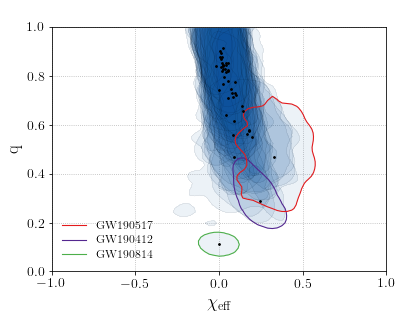

In [205]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(resampled_q_w190814.shape[0]):
    
    chis = resampled_x_w190814[i,:]
    qs = resampled_q_w190814[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    i190517=np.where(np.array(list(posteriors_w190814.keys()))=='S190517h')[0][0]
    i190412=np.where(np.array(list(posteriors_w190814.keys()))=='S190412m')[0][0]
    i190814=np.where(np.array(list(posteriors_w190814.keys()))=='S190814bv')[0][0]
    
    if i==i190517:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif i==i190412:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    elif i==i190814:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#4daf4a',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)

    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)
 

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1),
                Line2D([0], [0], color='#4daf4a', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412', 'GW190814'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)



ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)
ax.set_title(' ',fontsize=20)

"""ax.text(0.94,0.08, ' (a)', horizontalalignment='right', 
        verticalalignment='center', transform=ax.transAxes,fontsize=15, backgroundcolor='white')"""

plt.savefig('./reweighted_posterior_scatter_yesEvolution_w190814.pdf',bbox_inches='tight')

"ax.text(0.94,0.08, ' (a)', horizontalalignment='right', \n        verticalalignment='center', transform=ax.transAxes,fontsize=15, backgroundcolor='white')"

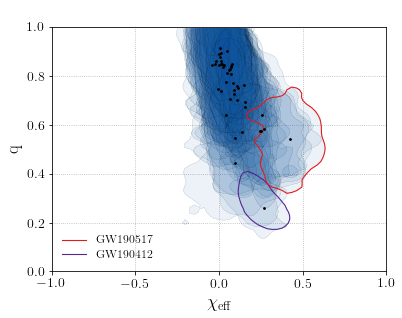

In [22]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(resampled_q_bivariateGaussian.shape[0]):
    
    chis = resampled_x_bivariateGaussian[i,:]
    qs = resampled_q_bivariateGaussian[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    i190517=np.where(np.array(list(posteriors.keys()))=='S190517h')[0][0]
    i190412=np.where(np.array(list(posteriors.keys()))=='S190412m')[0][0]
    
    if i==i190517:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    elif i==i190412:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#54278f',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)

    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)
 

custom_lines = [Line2D([0], [0], color='#e31a1c', lw=1.1),
                Line2D([0], [0], color='#54278f', lw=1.1)]
ax.legend(custom_lines, ['GW190517', 'GW190412'],loc='lower left',fontsize=12,frameon=False,labelspacing=0.3)



ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)
ax.set_title(' ',fontsize=20)

"""ax.text(0.94,0.08, ' (a)', horizontalalignment='right', 
        verticalalignment='center', transform=ax.transAxes,fontsize=15, backgroundcolor='white')"""

#plt.savefig('./reweighted_posterior_scatter_yesEvolution_w190814.pdf',bbox_inches='tight')

# Blob plot, injections

In [206]:
injection_samps_bpl = np.load('../../injection-study/processed_emcee_samples_injection_bpl_r00.npy')
injection_samps_plPeak = np.load('../../injection-study/processed_emcee_samples_injection_plPeak_r02.npy')
n_catalogs = 400

In [209]:
sampleDictInjected = {}
singleEvents = np.sort(glob.glob('../../injection-study/tmp/job*'))
for i,eventFile in enumerate(singleEvents):
    key = eventFile.split('_')[1].split('.')[0]
    dataDict = np.load(eventFile,allow_pickle=True,encoding='latin1')[()]
    sampleDictInjected[key] = dataDict

03611 0.2586225741912819 0.36044911342943453
09738 -0.24549122389795594 0.424725619706357
16297 0.007264717049497391 0.26662095509277095
27984 0.3105519022694915 0.42945965387693796
32545 -0.02938678942691968 0.37341325495681454


(0.0, 1.0)

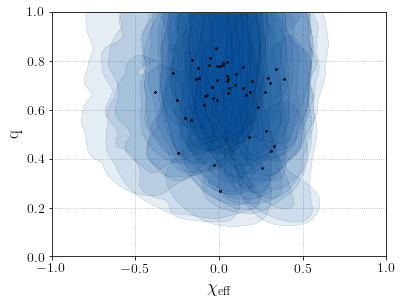

In [211]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i,key in enumerate(list(sampleDictInjected.keys())):
    
    chis = sampleDictInjected[key]['Xeff']
    m1s = sampleDictInjected[key]['m1']
    m2s = sampleDictInjected[key]['m2']
    qs = m2s/m1s
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,2)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    if np.median(qs)<0.45:
        print(key,np.median(chis),np.median(qs))
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.1)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

In [221]:
# Define a function to reweight to an isotropic prior on s1z and s2z, rather than an aligned prior
def isotropic_pz(szs,aMax):
    return np.log(aMax/np.abs(szs))/(2.*aMax)

reweightedSampleDictInjected = {}
bilby_output_files = np.sort(glob.glob('../../injection-study/output/job_?????_result.json'))
for i,f in enumerate(bilby_output_files):
    
    with open(f,'r') as jf:
        result = json.load(jf)

    m1 = np.array(result['posterior']['content']['mass_1_source'])
    m2 = np.array(result['posterior']['content']['mass_2_source'])
    s1 = np.array(result['posterior']['content']['spin_1z'])
    s2 = np.array(result['posterior']['content']['spin_2z'])
    
    qs = m2/m1
    chis = (m1*s1 + m2*s2)/(m1+m2)
    
    p_szs = isotropic_pz(s1,1.)*isotropic_pz(s2,1.)
    draw_probs = p_szs/np.sum(p_szs)
    
    chosenInds = np.random.choice(np.arange(qs.size),size=2000,replace=True,p=draw_probs)
    qs = qs[chosenInds]
    chis = chis[chosenInds]
    
    reweightedSampleDictInjected[i] = {'q':qs,'x':chis}
    
    print(f)
    print(1./np.max(draw_probs))

../../injection-study/output/job_02121_result.json
1728.9184110943913
../../injection-study/output/job_02405_result.json
3653.1037427590154
../../injection-study/output/job_02688_result.json
1481.7538133372257
../../injection-study/output/job_03611_result.json
3110.364279252653
../../injection-study/output/job_04003_result.json
1727.5004377801029
../../injection-study/output/job_04158_result.json
1856.9409223072234
../../injection-study/output/job_04546_result.json
2830.891522314026
../../injection-study/output/job_06677_result.json
2655.8450435268924
../../injection-study/output/job_07289_result.json
1401.2150662585702
../../injection-study/output/job_07842_result.json
1671.051986194712
../../injection-study/output/job_08792_result.json
1951.7784121140905
../../injection-study/output/job_08909_result.json
838.7770190479383
../../injection-study/output/job_08918_result.json
2430.6463367490737
../../injection-study/output/job_09738_result.json
1574.1616526296534
../../injection-study/ou

3 0.18507342294131118 0.3376891817739034
13 -0.17379087040582558 0.3903529894471225
22 0.0025771198972294913 0.2651207915940439
24 0.26892562501976225 0.44829928272054426
32 0.2561255338908383 0.3952611805682736
37 -0.021859500786946325 0.357118101801451


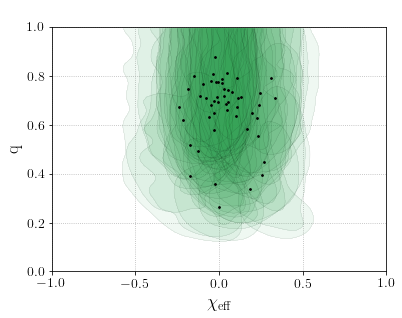

In [226]:
fig,ax = plt.subplots(figsize=(6,4.5))
chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for key in list(reweightedSampleDictInjected.keys()):
    
    chis = reweightedSampleDictInjected[key]['x']
    qs = reweightedSampleDictInjected[key]['q']

    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,2)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    if np.median(qs)<0.45:
        print(key,np.median(chis),np.median(qs))
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)
    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#31a354',alpha=0.075)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

ax.set_title(' ',fontsize=20)
plt.savefig('injection_blob.pdf',bbox_inches='tight')
plt.show()

# Predictive check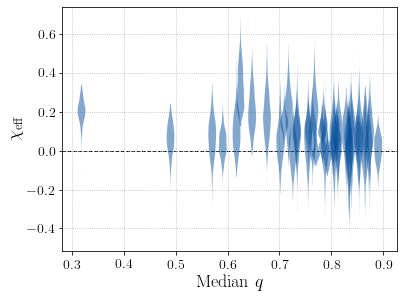

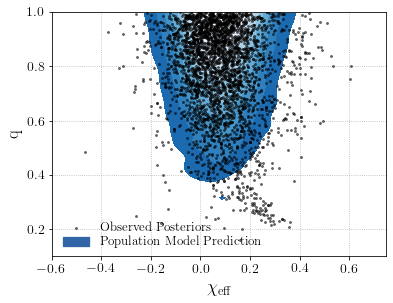

In [9]:
fig = plt.figure(figsize=(6,4.5))

cats = np.random.choice(np.arange(resampled_x_noEvol.shape[1]),size=75,replace=False)
ax = fig.add_subplot(111)

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]
    
heights,edgex,edgey = np.histogram2d(mock_x_noEvol.reshape(-1),mock_q_noEvol.reshape(-1),bins=(chi_grid,q_grid))
heights = gaussian_filter(heights,1.5)
heights /= np.sum(heights)*dchi*dq
heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
"""num_grid_pts = np.where(cdf>0.9)[0][0]
h90 = np.interp(0.9,cdf,heights_large_to_small)
h50 = np.interp(0.5,cdf,heights_large_to_small)
h10 = np.interp(0.1,cdf,heights_large_to_small)
ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,h50,h10,np.inf),colors='black',linewidths=1.3,zorder=1)
"""

num_grid_pts = np.where(cdf>0.9)[0][0]
h90 = np.interp(0.9,cdf,heights_large_to_small)
h80 = np.interp(0.8,cdf,heights_large_to_small)
h70 = np.interp(0.7,cdf,heights_large_to_small)
h60 = np.interp(0.6,cdf,heights_large_to_small)
h50 = np.interp(0.5,cdf,heights_large_to_small)
h40 = np.interp(0.4,cdf,heights_large_to_small)
h30 = np.interp(0.3,cdf,heights_large_to_small)
h20 = np.interp(0.2,cdf,heights_large_to_small)
h10 = np.interp(0.1,cdf,heights_large_to_small)

ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,h80,h70,h60,h50,h40,h30,h20,h10,np.inf),cmap=cm.Blues_r,vmin=-1,vmax=h10)

ax.scatter(resampled_x_noEvol[:,cats].reshape(-1),resampled_q_noEvol[:,cats].reshape(-1),marker='.',color='black',s=15,zorder=2,alpha=0.5,label='Observed Posteriors')

ax.set_xlim(-0.6,0.75)
ax.set_ylim(0.1,1)
ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)

custom_lines = [Rectangle((0,0),0,0, color='#3265A7', lw=1.3)]
leg2 = plt.legend(custom_lines, ['Population Model Prediction'],loc=(0.02,0.01),fontsize=13,frameon=False,labelspacing=0.3)

ax.legend(frameon=False,loc=(0.02,0.07),fontsize=13)
ax.add_artist(leg2)

#plt.savefig('./obs_scatter.pdf',bbox_inches='tight')
plt.show()

In [10]:
obs_slope = np.zeros(n_catalogs)
mock_slope = np.zeros(n_catalogs)

obs_r = np.zeros(n_catalogs)
mock_r = np.zeros(n_catalogs)

obs_chisq = np.zeros(n_catalogs)
mock_chisq = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol[:,i]
    mock_qs = mock_q_noEvol[:,i]
    obs_xs = resampled_x_noEvol[:,i]
    mock_xs = mock_x_noEvol[:,i]
    
    X = np.transpose([np.ones(obs_qs.size),obs_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(obs_xs)
    obs_slope[i] = m
    
    chisq = np.sum(np.power(obs_xs - (m*obs_qs+b),2.))
    obs_chisq[i] = chisq
    
    X = np.transpose([np.ones(mock_qs.size),mock_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(mock_xs)
    mock_slope[i] = m
    
    chisq = np.sum(np.power(mock_xs - (m*mock_qs+b),2.))
    mock_chisq[i] = chisq
    
    r = np.mean((obs_qs - np.mean(obs_qs))*(obs_xs - np.mean(obs_xs)))/(np.std(obs_qs)*np.std(obs_xs))
    obs_r[i] = r
    
    r = np.mean((mock_qs - np.mean(mock_qs))*(mock_xs - np.mean(mock_xs)))/(np.std(mock_qs)*np.std(mock_xs))
    mock_r[i] = r
    
    

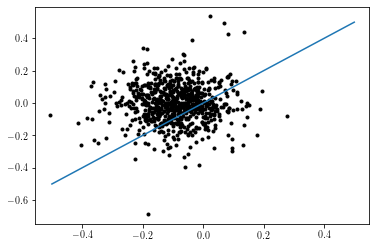

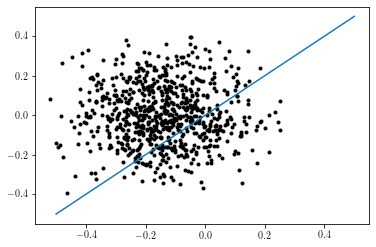

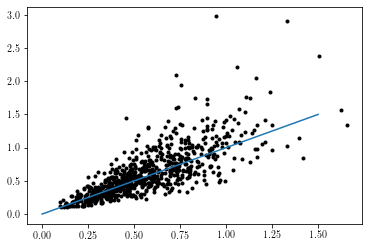

In [106]:
fig,ax = plt.subplots()
ax.scatter(obs_slope,mock_slope,marker='.',color='black')
ax.plot([-0.5,0.5],[-0.5,0.5])
plt.show()

fig,ax = plt.subplots()
ax.scatter(obs_r,mock_r,marker='.',color='black')
ax.plot([-0.5,0.5],[-0.5,0.5])
plt.show()

fig,ax = plt.subplots()
ax.scatter(obs_chisq,mock_chisq,marker='.',color='black')
ax.plot([0,1.5],[0,1.5])
plt.show()

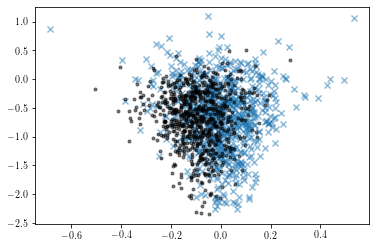

In [123]:
fig,ax = plt.subplots()
ax.scatter(mock_slope,np.log(mock_chisq),marker='x',alpha=0.5)
ax.scatter(obs_slope,np.log(obs_chisq),marker='.',color='black',alpha=0.5)

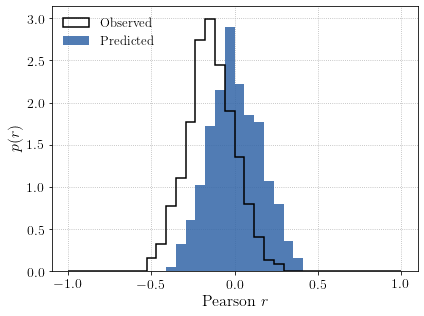

In [105]:
fig = plt.figure(figsize=(6,4.5))

ax = fig.add_subplot(111)
ax.hist(obs_r,label='Observed',bins=np.linspace(-1,1,35),density=True,color='black',histtype='step',lw=1.5)
ax.hist(mock_r,alpha=0.85,label='Predicted',bins=np.linspace(-1,1,35),color='#3265A7',density=True)
plt.legend(loc='upper left',fontsize=13,frameon=False)
#ax.set_xlim(-0.6,0.6)
ax.set_xlabel("Pearson $r$",fontsize=16)
ax.set_ylabel(r"$p(r)$",fontsize=16)

ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)

"""ax.text(0.94,0.08, '(b)', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,fontsize=15)"""

plt.tight_layout()
plt.show()

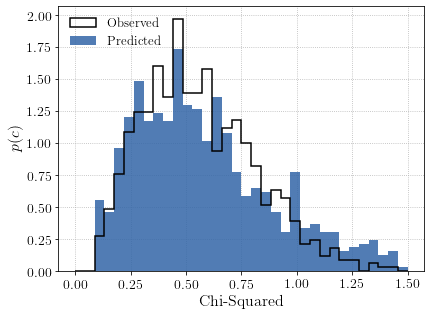

In [107]:
fig = plt.figure(figsize=(6,4.5))

ax = fig.add_subplot(111)
ax.hist(obs_chisq,label='Observed',bins=np.linspace(0,1.5,35),density=True,color='black',histtype='step',lw=1.5)
ax.hist(mock_chisq,alpha=0.85,label='Predicted',bins=np.linspace(0,1.5,35),color='#3265A7',density=True)
plt.legend(loc='upper left',fontsize=13,frameon=False)
#ax.set_xlim(-0.6,0.6)
ax.set_xlabel("Chi-Squared",fontsize=16)
ax.set_ylabel(r"$p(c)$",fontsize=16)

ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

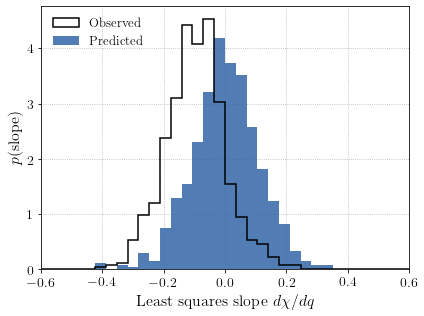

In [11]:
fig = plt.figure(figsize=(6,4.5))

ax = fig.add_subplot(111)
ax.hist(obs_slope,label='Observed',bins=np.linspace(-0.6,0.6,35),density=True,color='black',histtype='step',lw=1.5)
ax.hist(mock_slope,alpha=0.85,label='Predicted',bins=np.linspace(-0.6,0.6,35),color='#3265A7',density=True)
plt.legend(loc='upper left',fontsize=13,frameon=False)
ax.set_xlim(-0.6,0.6)
ax.set_xlabel("Least squares slope $d\chi/dq$",fontsize=16)
ax.set_ylabel(r"$p(\mathrm{slope})$",fontsize=16)

ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)

plt.tight_layout()
#plt.savefig('slopes_noEvol.pdf',bbox_inches='tight')
plt.show()

In [176]:
print(np.where(obs_slope<mock_slope)[0].size/n_catalogs)
print(np.where(obs_r<mock_r)[0].size/n_catalogs)

0.744
0.7453333333333333


In [71]:
# Next, sort catalogs by q and get the mean value of the lowest-q event, the second lowest q event, etc. etc.
obs_q_sortByQ = np.zeros(resampled_q_noEvol.shape)
obs_x_sortByQ = np.zeros(resampled_x_noEvol.shape)

for i in range(n_catalogs):
    
    sort_by_q = np.argsort(resampled_q_noEvol[:,i])
    obs_q_sortByQ[:,i] = resampled_q_noEvol[sort_by_q,i]
    obs_x_sortByQ[:,i] = resampled_x_noEvol[sort_by_q,i]

mean_sorted_q = np.mean(obs_q_sortByQ,axis=1)
mean_sorted_x = np.mean(obs_x_sortByQ,axis=1)
X = np.transpose([np.ones(mean_sorted_q.size),mean_sorted_q])
b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(mean_sorted_x)
print(m)

-0.09039843794733696


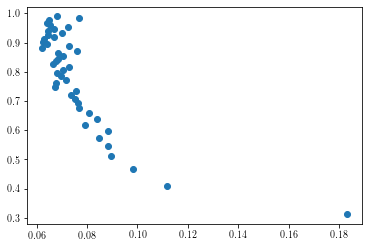

In [72]:
fig,ax = plt.subplots()
ax.scatter(np.mean(obs_x_sortByQ,axis=1),np.mean(obs_q_sortByQ,axis=1))
plt.show()

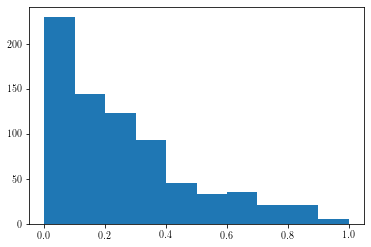

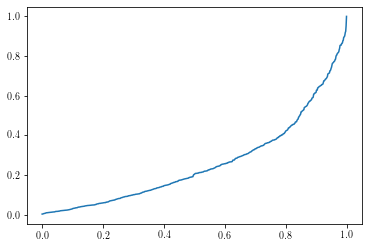

In [55]:
p_kde = gaussian_kde(mock_slope)

slope_grid = np.linspace(-1,1,300)
c_grid = np.cumsum(p_kde(slope_grid))*(slope_grid[1]-slope_grid[0])
p_vals = np.interp(obs_slope,slope_grid,c_grid)

fig,ax = plt.subplots()
ax.hist(p_vals)
plt.show()

fig,ax = plt.subplots()
ax.plot(np.linspace(0,1,p_vals.size),np.sort(p_vals))
plt.show()

In [51]:
np.quantile(p_vals,0.5)

0.20328327640789273

In [177]:
obs_slope_evol = np.zeros(n_catalogs)
mock_slope_evol = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q[:,i]
    mock_qs = mock_q[:,i]
    obs_xs = resampled_x[:,i]
    mock_xs = mock_x[:,i]
    
    X = np.transpose([np.ones(obs_qs.size),obs_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(obs_xs)
    obs_slope_evol[i] = m
    
    X = np.transpose([np.ones(mock_qs.size),mock_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(mock_xs)
    mock_slope_evol[i] = m

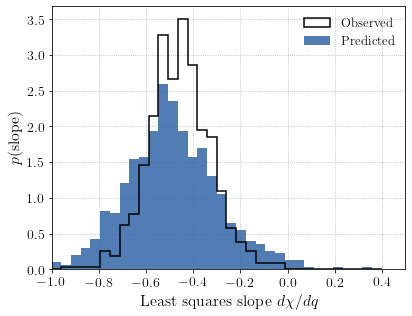

In [152]:
fig = plt.figure(figsize=(6,4.5))

ax = fig.add_subplot(111)
ax.hist(obs_slope_evol,label='Observed',bins=np.linspace(-1,0.4,35),density=True,color='black',histtype='step',lw=1.5)
ax.hist(mock_slope_evol,alpha=0.85,label='Predicted',bins=np.linspace(-1,0.4,35),color='#3265A7',density=True)
plt.legend(loc='upper right',fontsize=13,frameon=False)
ax.set_xlim(-1,0.5)
ax.set_xlabel("Least squares slope $d\chi/dq$",fontsize=16)
ax.set_ylabel(r"$p(\mathrm{slope})$",fontsize=16)

ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)

"""ax.text(0.94,0.08, '(b)', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,fontsize=15)"""

plt.tight_layout()
plt.savefig('slopes_evol.pdf',bbox_inches='tight')
plt.show()

In [185]:
np.where(obs_slope_evol<mock_slope_evol)[0].size/n_catalogs

with open('macros_ppc.txt','w') as macrofile:
    
    percentage = int(100.*(np.where(obs_slope<mock_slope)[0].size/n_catalogs))
    macrofile.write('\\newcommand{{\\FracBelow}}{{{0}\\%}}'.format(percentage))
    macrofile.write('\n')
    
    mean = np.mean(obs_slope)
    macrofile.write('\\newcommand{{\\meanObsSlopeBase}}{{{0:.1f}}}'.format(mean))
    macrofile.write('\n')
    
    mean_evol = np.mean(obs_slope_evol)
    mean_evol_predicted = np.mean(mock_slope_evol)
    macrofile.write('\\newcommand{{\\meanObsSlopeEvol}}{{{0:.2f}}}'.format(mean_evol))
    macrofile.write('\n')
    macrofile.write('\\newcommand{{\\meanMockSlopeEvol}}{{{0:.2f}}}'.format(mean_evol_predicted))

In [174]:
print(np.mean(mock_slope),np.std(mock_slope)/np.sqrt(mock_slope.size))
print(np.mean(obs_slope),np.std(obs_slope)/np.sqrt(obs_slope.size))

-0.49064586251109193 0.007460412593632754
-0.4577299431602734 0.004917103271834143


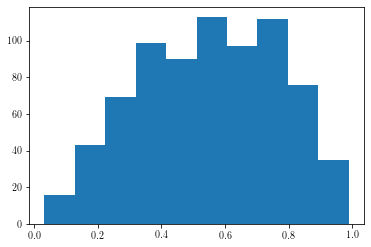

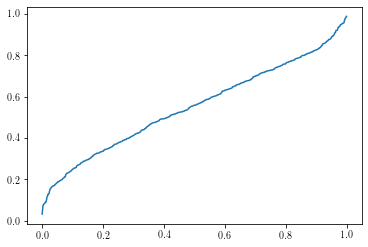

In [29]:
p_kde = gaussian_kde(mock_slope)

slope_grid = np.linspace(-1.5,1.5,300)
c_grid = np.cumsum(p_kde(slope_grid))*(slope_grid[1]-slope_grid[0])
p_vals = np.interp(obs_slope,slope_grid,c_grid)

fig,ax = plt.subplots()
ax.hist(p_vals)
plt.show()

fig,ax = plt.subplots()
ax.plot(np.linspace(0,1,p_vals.size),np.sort(p_vals))
plt.show()

# Predictive Check w/out 190412

In [17]:
mock_q_noEvol_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))
mock_x_noEvol_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))

resampled_q_noEvol_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))
resampled_x_noEvol_no190412 = np.zeros((len(posteriors_no190412),n_catalogs))

for i in range(n_catalogs):
    
    samp = np.random.choice(np.arange(samps_no_evol_no190412.shape[0]))
    
    mMin = 5.
    lmbda = samps_no_evol_no190412[samp,0]
    mMax = samps_no_evol_no190412[samp,1]
    m0 = samps_no_evol_no190412[samp,2]
    sigM = samps_no_evol_no190412[samp,3]
    fPeak = samps_no_evol_no190412[samp,4]
    bq = samps_no_evol_no190412[samp,5]
    kappa = samps_no_evol_no190412[samp,6]
    mu0 = samps_no_evol_no190412[samp,7]
    logsig0 = samps_no_evol_no190412[samp,8]
    
    p_det_m1_pl = (1.+lmbda)*m1_det**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
    p_det_m1_pl[m1_det>mMax] = 0
    p_det_m1_peak = np.exp(-0.5*(m1_det-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
    mock_p_m1 = fPeak*p_det_m1_peak + (1.-fPeak)*p_det_m1_pl
    
    mock_p_m2 = (1.+bq)*np.power(m2_det,bq)/(np.power(m1_det,1.+bq)-mMin**(1.+bq))
    mock_p_m2[m2_det<mMin]=0
    
    mock_p_z = np.power(1.+z_det,kappa-1.)
    mock_p_chi = calculate_Gaussian(X_det, mu0, 10.**(2.*logsig0),-1.,1.)
    
    p_det = mock_p_m1*mock_p_m2*mock_p_z*mock_p_chi*pop_reweight
    p_det /= np.sum(p_det)
    
    try:
        detected_injections = np.random.choice(np.arange(m1_det.size),size=len(posteriors_no190412),p=p_det,replace=True)
        
    except ValueError:
        print(samp)
        
    mock_q_noEvol_no190412[:,i] = q_det[detected_injections]
    mock_x_noEvol_no190412[:,i] = X_det[detected_injections]

    for ii,key in enumerate(posteriors_no190412):

        chis = posteriors_no190412[key]['Xeff']
        Xeff_prior = posteriors_no190412[key]['Xeff_priors']
        m1s = posteriors_no190412[key]['m1']
        m2s = posteriors_no190412[key]['m2']
        zs = posteriors_no190412[key]['z']
        weights = posteriors_no190412[key]['weights']
        qs = m2s/m1s

        p_Chi = calculate_Gaussian(chis, mu0, 10.**(2.*logsig0),-1.,1.)

        # p(m1)
        p_m1_pl = (1.+lmbda)*m1s**lmbda/(mMax**(1.+lmbda) - mMin**(1.+lmbda))
        p_m1_pl[m1s>mMax] = 0.
        p_m1_peak = np.exp(-0.5*(m1s-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
        p_m1 = fPeak*p_m1_peak + (1.-fPeak)*p_m1_pl
        old_m1_prior = np.ones(m1s.size)

        # p(m2)
        p_m2 = (1.+bq)*np.power(m2s,bq)/(np.power(m1s,1.+bq)-mMin**(1.+bq))
        old_m2_prior = np.ones(m1s.size)
        p_m2[m2s<mMin]=0

        # p(z)
        p_z = np.power(1.+zs,kappa-1.)
        old_pz_prior = (1.+zs)**(2.7-1.)
        
        # Draw probs
        probs = p_Chi*p_m1*p_m2*p_z*weights/Xeff_prior/old_m1_prior/old_m2_prior/old_pz_prior
        
        if np.any(probs!=probs):
            print(np.where(probs!=probs))
            print(probs)
        probs[probs<0] = 0.
        probs /= np.sum(probs)
        chosenInd = np.random.choice(np.arange(m1s.size),p=probs)
        resampled_q_noEvol_no190412[ii,i] = qs[chosenInd]
        resampled_x_noEvol_no190412[ii,i] = chis[chosenInd]

(0.0, 1.0)

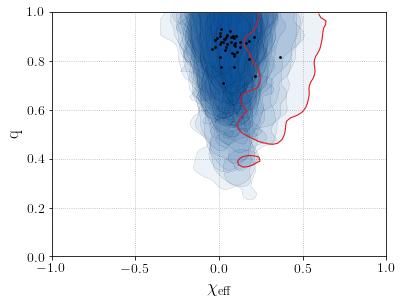

In [30]:
fig,ax = plt.subplots(figsize=(6,4.5))

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]

for i in range(resampled_q_noEvol_no190412.shape[0]):
    
    chis = resampled_x_noEvol_no190412[i,:]
    qs = resampled_q_noEvol_no190412[i,:]
    
    heights,edgex,edgey = np.histogram2d(chis,qs,bins=(chi_grid,q_grid))
    heights = gaussian_filter(heights,1.5)
    heights /= np.sum(heights)*dchi*dq
    heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
    cdf = np.cumsum(heights_large_to_small)*dchi*dq
    
    num_grid_pts = np.where(cdf>0.9)[0][0]
    h90 = np.interp(0.9,cdf,heights_large_to_small)
    
    ax.scatter([np.median(chis)],[np.median(qs)],color='black',zorder=100,s=3)
    
    i190517=np.where(np.array(list(posteriors_no190412.keys()))=='S190517h')[0][0]
    
    if i==i190517:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#e31a1c',linewidths=1.1)
    else:
        ax.contour((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='black',linewidths=0.3,alpha=0.2)

    ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,np.inf),colors='#08519c',alpha=0.075)

ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

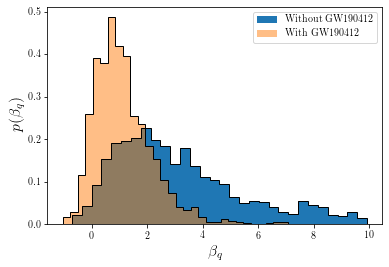

In [46]:
fig,ax = plt.subplots()
ax.hist(samps_no_evol_no190412[:,5],histtype='stepfilled',bins=30,label='Without GW190412',density=True)
ax.hist(samps_no_evol_no190412[:,5],histtype='step',bins=30,color='black',density=True)

ax.hist(samps_no_evol[:,5],histtype='stepfilled',bins=30,alpha=0.5,label='With GW190412',density=True)
ax.hist(samps_no_evol[:,5],histtype='step',bins=30,color='black',density=True)

ax.set_xlabel(r'$\beta_q$',fontsize=16)
ax.set_ylabel(r'$p(\beta_q)$',fontsize=16)
plt.legend(loc='upper right')

plt.show()

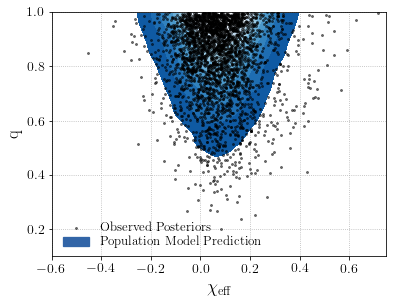

In [26]:
fig = plt.figure(figsize=(6,4.5))

cats = np.random.choice(np.arange(resampled_x_noEvol_no190412.shape[1]),size=75,replace=False)
ax = fig.add_subplot(111)

chi_grid = np.linspace(-1,1,70)
q_grid = np.linspace(0,1,69)
dchi = chi_grid[1] - chi_grid[0]
dq = q_grid[1] - q_grid[0]
    
heights,edgex,edgey = np.histogram2d(mock_x_noEvol_no190412.reshape(-1),mock_q_noEvol_no190412.reshape(-1),bins=(chi_grid,q_grid))
heights = gaussian_filter(heights,1.5)
heights /= np.sum(heights)*dchi*dq
heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
cdf = np.cumsum(heights_large_to_small)*dchi*dq

num_grid_pts = np.where(cdf>0.9)[0][0]
h90 = np.interp(0.9,cdf,heights_large_to_small)
h80 = np.interp(0.8,cdf,heights_large_to_small)
h70 = np.interp(0.7,cdf,heights_large_to_small)
h60 = np.interp(0.6,cdf,heights_large_to_small)
h50 = np.interp(0.5,cdf,heights_large_to_small)
h40 = np.interp(0.4,cdf,heights_large_to_small)
h30 = np.interp(0.3,cdf,heights_large_to_small)
h20 = np.interp(0.2,cdf,heights_large_to_small)
h10 = np.interp(0.1,cdf,heights_large_to_small)

ax.contourf((chi_grid[:-1]+chi_grid[1:])/2,(q_grid[:-1]+q_grid[1:])/2,heights.T,levels=(h90,h80,h70,h60,h50,h40,h30,h20,h10,np.inf),cmap=cm.Blues_r,vmin=-1,vmax=h10)
ax.scatter(resampled_x_noEvol_no190412[:,cats].reshape(-1),resampled_q_noEvol_no190412[:,cats].reshape(-1),marker='.',color='black',s=15,zorder=2,alpha=0.5,label='Observed Posteriors')

ax.set_xlim(-0.6,0.75)
ax.set_ylim(0.1,1)
ax.set_xlabel(r'$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'q',fontsize=18)
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)

custom_lines = [Rectangle((0,0),0,0, color='#3265A7', lw=1.3)]
leg2 = plt.legend(custom_lines, ['Population Model Prediction'],loc=(0.02,0.01),fontsize=13,frameon=False,labelspacing=0.3)

ax.legend(frameon=False,loc=(0.02,0.07),fontsize=13)
ax.add_artist(leg2)

"""ax.text(0.94,0.08, '(a)', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes,fontsize=15)"""

plt.show()

In [47]:
obs_slope = np.zeros(n_catalogs)
mock_slope = np.zeros(n_catalogs)

obs_r = np.zeros(n_catalogs)
mock_r = np.zeros(n_catalogs)

obs_chisq = np.zeros(n_catalogs)
mock_chisq = np.zeros(n_catalogs)

for i in range(n_catalogs):
    
    obs_qs = resampled_q_noEvol_no190412[:,i]
    mock_qs = mock_q_noEvol_no190412[:,i]
    obs_xs = resampled_x_noEvol_no190412[:,i]
    mock_xs = mock_x_noEvol_no190412[:,i]
    
    X = np.transpose([np.ones(obs_qs.size),obs_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(obs_xs)
    obs_slope[i] = m
    
    X = np.transpose([np.ones(mock_qs.size),mock_qs])
    b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(mock_xs)
    mock_slope[i] = m

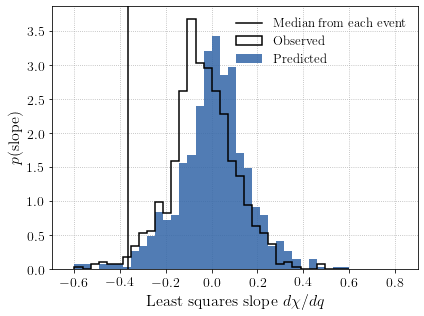

-0.03696337445452393


In [58]:
fig = plt.figure(figsize=(6,4.5))

ax = fig.add_subplot(111)
ax.hist(obs_slope,label='Observed',bins=np.linspace(-0.6,0.6,35),density=True,color='black',histtype='step',lw=1.5)
ax.hist(mock_slope,alpha=0.85,label='Predicted',bins=np.linspace(-0.6,0.6,35),color='#3265A7',density=True)
ax.axvline(x=median_slope,color='black',label='Median from each event')

plt.legend(loc='upper right',fontsize=13,frameon=False)
ax.set_xlim(-0.7,0.9)
ax.set_xlabel("Least squares slope $d\chi/dq$",fontsize=16)
ax.set_ylabel(r"$p(\mathrm{slope})$",fontsize=16)

ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)

plt.tight_layout()
#plt.savefig('slopes_noEvol.pdf',bbox_inches='tight')
plt.show()

print(np.mean(obs_slope))

In [28]:
med_xs = np.median(resampled_x_noEvol_no190412,axis=1)
med_qs = np.median(resampled_q_noEvol_no190412,axis=1)
X = np.transpose([np.ones(med_qs.size),med_qs])
b,m = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(med_xs)
median_slope = m
median_intercept = b
print(median_slope)

-0.36793835945201325


# Trace plots

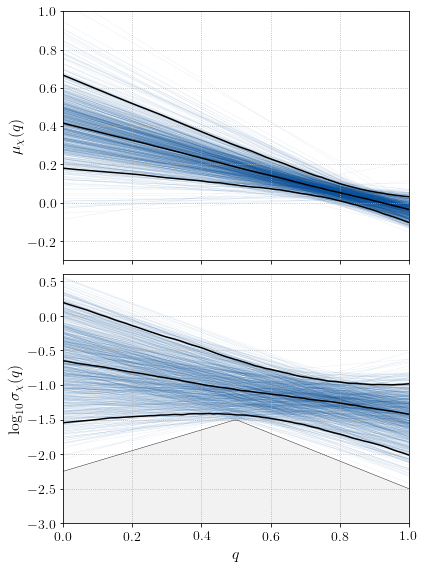

In [62]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.2

fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

qs = np.linspace(0,1,100)
mu_qs = np.zeros((qs.size,samps.shape[0]))
logsig_qs = np.zeros((qs.size,samps.shape[0]))
for i in range(samps.shape[0]):
    
    mu0 = samps[i,7]
    logsig0 = samps[i,8]
    alpha = samps[i,9]
    beta = samps[i,10]
    
    mus = mu0 + alpha*(qs-0.5)
    logsigs = logsig0 + beta*(qs-0.5)
    
    mu_qs[:,i] = mus
    logsig_qs[:,i] = logsigs
    
    ax1.plot(qs,mus,color='#08519c',alpha=0.2,lw=0.2,zorder=-2)
    ax2.plot(qs,logsigs,color='#08519c',alpha=0.2,lw=0.2,zorder=-2)
    
ax1.plot(qs, np.quantile(mu_qs,0.5,axis=1), color='black')
ax1.plot(qs, np.quantile(mu_qs,0.05,axis=1), color='black')
ax1.plot(qs, np.quantile(mu_qs,0.95,axis=1), color='black')

ax2.plot(qs, np.quantile(logsig_qs,0.5,axis=1), color='black')
ax2.plot(qs, np.quantile(logsig_qs,0.05,axis=1), color='black')
ax2.plot(qs, np.quantile(logsig_qs,0.95,axis=1), color='black')

ax2.plot(qs, np.minimum(-1.5 + (-2)*(qs-0.5), -1.5 + 1.5*(qs-0.5)),color='black',lw=0.4)
ax2.fill_between(qs, np.minimum(-1.5 + (-2)*(qs-0.5), -1.5 + 1.5*(qs-0.5)), y2=-3, facecolor='grey',alpha=0.1)

ax1.set_rasterization_zorder(-1)
ax1.set_xlim(0,1)
ax1.set_ylim(-0.3,1.0)
ax1.xaxis.grid(True,which='major',ls=':')
ax1.yaxis.grid(True,which='major',ls=':')
ax1.set_axisbelow(True)
ax1.tick_params(labelsize=14)
ax1.set_xticklabels([])
#ax1.set_xlabel(r"$q$",fontsize=16)
ax1.set_ylabel(r"$\mu_\chi(q)$",fontsize=16)
#ax1.text(0.94,0.08, '(a)', horizontalalignment='center',
#        verticalalignment='center', transform=ax1.transAxes,fontsize=15)

ax2.set_rasterization_zorder(-1)
ax2.set_xlim(0,1)
ax2.set_ylim(-3,0.6)
ax2.xaxis.grid(True,which='major',ls=':')
ax2.yaxis.grid(True,which='major',ls=':')
ax2.set_axisbelow(True)
ax2.tick_params(labelsize=14)
ax2.set_xlabel(r"$q$",fontsize=16)
ax2.set_ylabel(r"$\log_{10}\sigma_\chi(q)$",fontsize=16)
#ax2.text(0.94,0.08, '(b)', horizontalalignment='center',
#        verticalalignment='center', transform=ax2.transAxes,fontsize=15)
    
plt.tight_layout()
plt.savefig('tracePlot.pdf',bbox_inches='tight')
plt.show()

# Corner Plots

In [3]:
# Helper function to obtain 90% credible bounds from a list of samples
# Invoked by plot_corner to create labels on 1D posteriors
def getBounds(data):
    
    # Transform to a numpy arry
    data = np.array(data)

    # Get median, 5% and 95% quantiles
    med = np.median(data)
    upperLim = np.sort(data)[int(0.95*data.size)]
    lowerLim = np.sort(data)[int(0.05*data.size)]
 
    # Turn quantiles into upper and lower uncertainties
    upperError = upperLim-med
    lowerError = med-lowerLim
    
    return med,upperError,lowerError
    
def plot_corner(fig,plot_data,color,hist_alpha=0.7,bins=20,labelsize=14,kernel=2,lw=1):
    
    # Input variable plot_data should be a dictionary whose keys are the individual variables to plot.
    # Each key should, in turn, link to another nested dictionary with the following keys:
    # - "data" : Actual data values
    # - "plot_bounds" : Tuple of min/max values to display on plot
    # - "label" : Latex string for figure labeling

    # Define a linear color map
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",color])
    
    # Loop across dimensions that we want to plot
    keys = list(plot_data)    
    ndim = len(keys)
    for i,key in enumerate(keys):
       
        # Plot the marginal 1D posterior (i.e. top of a corner plot column)
        ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
        #ax.set_rasterization_zorder(1)
        
        ax.hist(plot_data[key]['data'],bins=np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],bins),\
               rasterized=True,color=color,alpha=hist_alpha,density=True,zorder=0)
        ax.hist(plot_data[key]['data'],bins=np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],bins),\
                histtype='step',color='black',density=True,zorder=2,lw=lw)
        ax.grid(True,dashes=(1,3))
        ax.set_xlim(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1])
        ax.set_title(r"${0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(*getBounds(plot_data[key]['data'])),fontsize=14)

        # Turn off tick labels if this isn't the first dimension
        if i!=0:
            ax.set_yticklabels([])

        # If this is the last dimension add an x-axis label
        if i==ndim-1:
            ax.set_xlabel(plot_data[key]['label'],fontsize=labelsize)
            
        # If not the last dimension, loop across other variables and fill in the rest of the column with 2D plots
        else:
                        
            ax.set_xticklabels([])
            for j,k in enumerate(keys[i+1:]):
                                
                # Make a 2D density plot
                ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))
                #ax.set_rasterization_zorder(1)
                
                ax.hexbin(plot_data[key]['data'],plot_data[k]['data'],cmap=cmap,mincnt=1,gridsize=bins,\
                         extent=(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1]),
                         linewidths=(0,),zorder=0)
                
                xgrid = np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],100)
                ygrid = np.linspace(plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1],100)
                dx = xgrid[1]-xgrid[0]
                dy = ygrid[1]-ygrid[0]
                
                heights,edgex,edgey = np.histogram2d(plot_data[key]['data'],plot_data[k]['data'],
                                                     bins=(xgrid,ygrid))
                heights = gaussian_filter(heights,kernel)
                heights /= np.sum(heights)*dx*dy
                heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
                cdf = np.cumsum(heights_large_to_small)*dx*dy

                num_grid_pts = np.where(cdf>0.9)[0][0]
                h50 = np.interp(0.5,cdf,heights_large_to_small)
                h90 = np.interp(0.9,cdf,heights_large_to_small)
                ax.contour((xgrid[:-1]+xgrid[1:])/2,(ygrid[:-1]+ygrid[1:])/2,heights.T,levels=(h90,h50,np.inf),colors='black',linewidths=1.1)
                
                # Set plot bounds
                ax.set_xlim(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1])
                ax.set_ylim(plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1])
                ax.grid(True,dashes=(1,3))
                
                # If still in the first column, add a y-axis label
                if i==0:
                    ax.set_ylabel(plot_data[k]['label'],fontsize=labelsize)
                else:
                    ax.set_yticklabels([])
               
                # If on the last row, add an x-axis label
                if j==ndim-i-2:
                    ax.set_xlabel(plot_data[key]['label'],fontsize=labelsize)
                else:
                    ax.set_xticklabels([])
                    
    return fig

def getBounds(samples):
    med = np.median(samples)
    upperError = np.quantile(samples,0.95) - np.median(samples)
    lowerError = np.median(samples) - np.quantile(samples,0.05)
    return med,upperError,lowerError

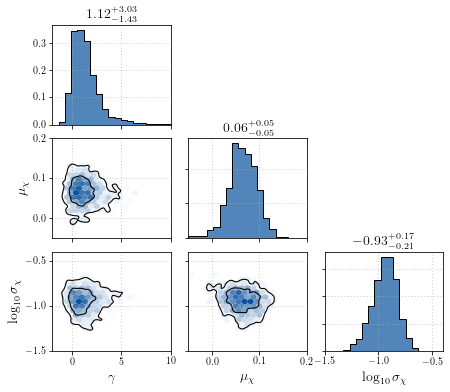

In [4]:
toPlot = {
    'beta':{'data':samps_no_evol[:,5],'plot_bounds':(-2,10),'label':r'$\gamma$'},
    'mu0':{'data':samps_no_evol[:,7],'plot_bounds':(-0.05,0.2),'label':r'$\mu_\chi$'},
    'sig0':{'data':samps_no_evol[:,8],'plot_bounds':(-1.5,-0.4),'label':r'$\log_{10}\sigma_\chi$'}
    }

with open('macros_pe_noEvol.txt','w') as macrofile:
    macrofile.write("\\newcommand{{\\noEvolMean}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".format(*getBounds(samps_no_evol[:,7])))
    macrofile.write("\n")
    macrofile.write("\\newcommand{{\\noEvolSigma}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".format(*getBounds(10.**samps_no_evol[:,8])))                
    macrofile.write("\n")
    macrofile.write("\\newcommand{{\\noEvolBetaq}}{{{0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}}}".format(*getBounds(samps_no_evol[:,5])))                

fig = plt.figure(figsize=(7,6))
plot_corner(fig,toPlot,'#08519c')
fig.subplots_adjust(wspace=0.15, hspace=0.14)
plt.savefig('./corner_noEvolution.pdf',bbox_inches='tight',dpi=200)
plt.show()

0.9870689655172413


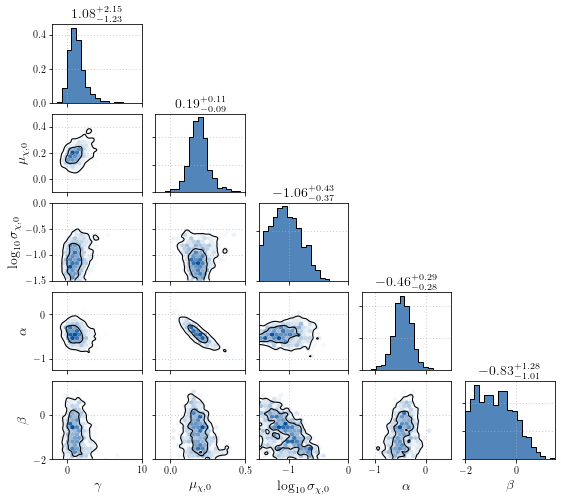

In [5]:
toPlot = {
    'beta':{'data':samps[:,5],'plot_bounds':(-2,10),'label':r'$\gamma$'},
    'mu0':{'data':samps[:,7],'plot_bounds':(-0.1,0.5),'label':r'$\mu_{\chi,0}$'},
    'sig0':{'data':samps[:,8],'plot_bounds':(-1.5,0.),'label':r'$\log_{10}\sigma_{\chi,0}$'},
    'a':{'data':samps[:,9],'plot_bounds':(-1.25,0.5),'label':r'$\alpha$'},
    'b':{'data':samps[:,10],'plot_bounds':(-2,1.5),'label':r'$\beta$'}
    }

with open('macros_pe_evol.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\evolMean}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".format(*getBounds(samps[:,7])))
    macrofile.write("\n")
    macrofile.write("\\newcommand{{\\evolSigma}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".format(*getBounds(10.**samps[:,8])))                
    macrofile.write("\n")
    macrofile.write("\\newcommand{{\\evolAlpha}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".format(*getBounds(samps[:,9])))                
    macrofile.write("\n")
    macrofile.write("\\newcommand{{\\evolBeta}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".format(*getBounds(samps[:,10])))                
    macrofile.write("\n")
    macrofile.write("\\newcommand{{\\evolBetaq}}{{{0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}}}".format(*getBounds(samps[:,5])))                
    macrofile.write("\n")
    
    alphas = samps[:,9]
    print(np.where(alphas<0)[0].size/alphas.size)
    percentNegative = (100.*np.where(alphas<0)[0].size/alphas.size)
    macrofile.write("\\newcommand{{\\percentAlphaNegative}}{{{0:.1f}\\%}}".format(percentNegative))                

    
fig = plt.figure(figsize=(9,8))
plot_corner(fig,toPlot,'#08519c',kernel=2.5)
fig.subplots_adjust(wspace=0.15, hspace=0.14)
plt.savefig('./corner_yesEvolution.pdf',bbox_inches='tight')
plt.show()

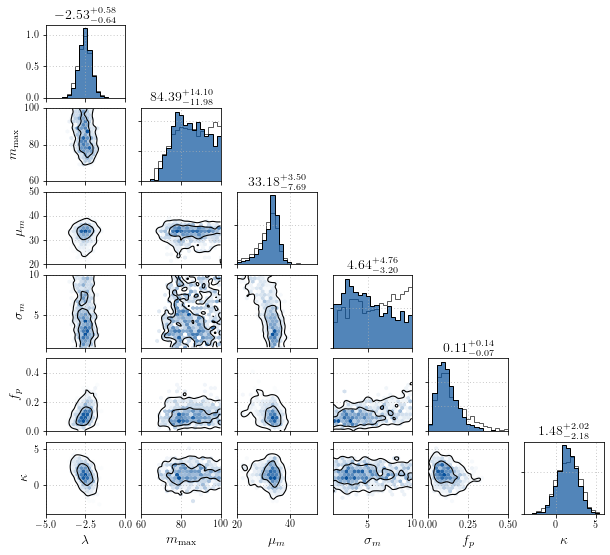

In [68]:
toPlot = {
    'lambda':{'data':samps[:,0],'plot_bounds':(-5,0),'label':r'$\lambda$'},
    'mMax':{'data':samps[:,1],'plot_bounds':(60,100),'label':r'$m_\mathrm{max}$'},
    'mu_m':{'data':samps[:,2],'plot_bounds':(20,50),'label':r'$\mu_m$'},
    'sig_m':{'data':samps[:,3],'plot_bounds':(1,10),'label':r'$\sigma_m$'},
    'f_p':{'data':samps[:,4],'plot_bounds':(0,0.5),'label':r'$f_p$'},
    'kappa':{'data':samps[:,6],'plot_bounds':(-4,6),'label':r'$\kappa$'}
}

fig = plt.figure(figsize=(10,9))
plot_corner(fig,toPlot,'#08519c',kernel=3)

axes = fig.axes
axes[0].hist(samps_no_evol[:,0],bins=np.linspace(-5,0,20),density=True,histtype='step',color='#5c5c5c',lw=1.,zorder=-1)
axes[6].hist(samps_no_evol[:,1],bins=np.linspace(60,100,20),density=True,histtype='step',color='#5c5c5c',lw=1.,zorder=-1)
axes[11].hist(samps_no_evol[:,2],bins=np.linspace(20,50,20),density=True,histtype='step',color='#5c5c5c',lw=1.,zorder=-1)
axes[15].hist(samps_no_evol[:,3],bins=np.linspace(1,10,20),density=True,histtype='step',color='#5c5c5c',lw=1.,zorder=-1)
axes[18].hist(samps_no_evol[:,4],bins=np.linspace(0,0.5,20),density=True,histtype='step',color='#5c5c5c',lw=1.,zorder=-1)
axes[20].hist(samps_no_evol[:,6],bins=np.linspace(-4,6,20),density=True,histtype='step',color='#5c5c5c',lw=1.,zorder=-1)

fig.subplots_adjust(wspace=0.2, hspace=0.15)
fig.savefig('./corner_yesEvolution_otherParams.pdf',bbox_inches='tight')
plt.show()

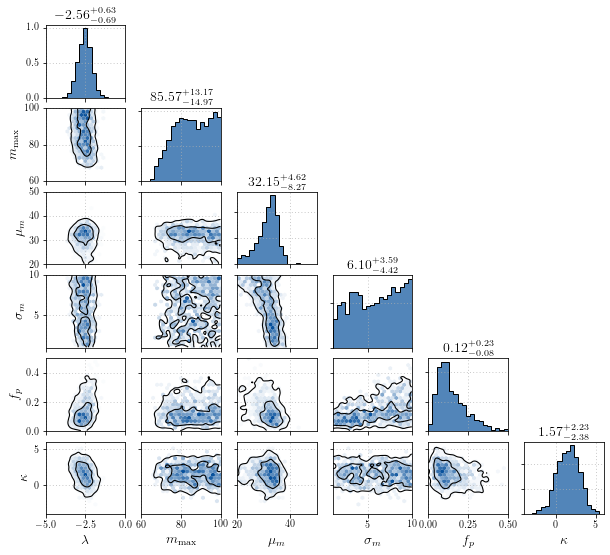

In [45]:
toPlot = {
    'lambda':{'data':samps_no_evol[:,0],'plot_bounds':(-5,0),'label':r'$\lambda$'},
    'mMax':{'data':samps_no_evol[:,1],'plot_bounds':(60,100),'label':r'$m_\mathrm{max}$'},
    'mu_m':{'data':samps_no_evol[:,2],'plot_bounds':(20,50),'label':r'$\mu_m$'},
    'sig_m':{'data':samps_no_evol[:,3],'plot_bounds':(1,10),'label':r'$\sigma_m$'},
    'f_p':{'data':samps_no_evol[:,4],'plot_bounds':(0,0.5),'label':r'$f_p$'},
    'kappa':{'data':samps_no_evol[:,6],'plot_bounds':(-4,6),'label':r'$\kappa$'}
}

fig = plt.figure(figsize=(10,9))
plot_corner(fig,toPlot,'#08519c',kernel=3)
fig.subplots_adjust(wspace=0.2, hspace=0.15)
fig.savefig('./corner_noEvolution_otherParams.pdf',bbox_inches='tight')
plt.show()

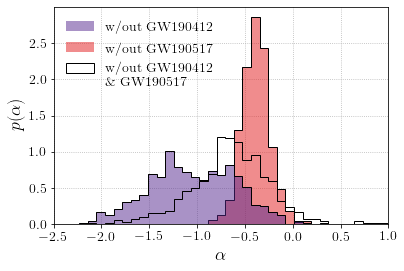

In [183]:
fig,ax = plt.subplots()

ax.hist(samps_no190412[:,9],bins=np.linspace(-2.5,1,40),histtype='stepfilled',
        color='#54278f',label='w/out GW190412',alpha=0.5,zorder=4,density=True)
ax.hist(samps_no190412[:,9],bins=np.linspace(-2.5,1,40),histtype='step',
        color='black',zorder=5,density=True)

ax.hist(samps_no190517[:,9],bins=np.linspace(-2.5,1,40),histtype='stepfilled',
        color='#e31a1c',label='w/out GW190517',alpha=0.5,zorder=2,density=True)
ax.hist(samps_no190517[:,9],bins=np.linspace(-2.5,1,40),histtype='step',
        color='black',zorder=3,density=True)


ax.hist(samps_no190412_no190517[:,9],bins=np.linspace(-2.5,1,40),histtype='step',
        color='black',density=True,zorder=10)

leg2 = plt.legend([Rectangle((0,0),1,1,facecolor='white',edgecolor='black')],['w/out GW190412 \n \& GW190517'],
                  fontsize=14,frameon=False,loc=(0.021,0.63))
leg2.get_texts()[0].set_position((0,-7.5))

leg = ax.legend(loc='upper left',fontsize=14,frameon=False)
plt.gca().add_artist(leg2)

ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel(r'$\alpha$',fontsize=18)
ax.set_ylabel(r'$p(\alpha)$',fontsize=18)
ax.set_xlim(-2.5,1.)

plt.savefig('./alpha_posterior_outInTests.pdf',bbox_inches='tight')

plt.show()

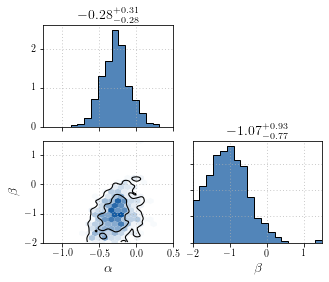

In [193]:
toPlot = {
    'a':{'data':samps_w190814[:,9],'plot_bounds':(-1.25,0.5),'label':r'$\alpha$'},
    'b':{'data':samps_w190814[:,10],'plot_bounds':(-2,1.5),'label':r'$\beta$'}
    }

fig = plt.figure(figsize=(5,4))
plot_corner(fig,toPlot,'#08519c')

"""ax = fig.axes[1]
ax.text(0.19,0.17, ' (b)', horizontalalignment='right', 
        verticalalignment='center', transform=ax.transAxes,fontsize=13)"""

fig.subplots_adjust(wspace=0.15, hspace=0.14)
fig.savefig('./corner_yesEvolution_w190814_small.pdf',bbox_inches='tight')
plt.show()

In [192]:
with open('macros_pe_evol_altEvents.txt','w') as macrofile:
    
    alphas = samps_no190517[:,9]
    percent_negative = 100.*alphas[alphas<0].size/alphas.size
    macrofile.write("\\newcommand{{\\percentAlphaNegativeNoOhFiveSeventeen}}{{{0:.1f}\\%}}".format(percent_negative)) 
    macrofile.write('\n')
    
    alphas = samps_no190412[:,9]
    percent_negative = 100.*alphas[alphas<0].size/alphas.size
    macrofile.write("\\newcommand{{\\percentAlphaNegativeNoOhFourTwelve}}{{{0:.1f}\\%}}".format(percent_negative)) 
    macrofile.write('\n')
    
    alphas = samps_no190412_no190517[:,9]
    percent_negative = 100.*alphas[alphas<0].size/alphas.size
    macrofile.write("\\newcommand{{\\percentAlphaNegativeNoOhFourTwelveOrOhFiveSeventeen}}{{{0:.1f}\\%}}".format(percent_negative)) 
    macrofile.write('\n')
    
    alphas = samps_w190814[:,9]
    betas = samps_w190814[:,10]
    percent_negative = 100.*alphas[alphas<0].size/alphas.size
    percent_negative_betas = 100.*betas[betas<0].size/betas.size
    macrofile.write("\\newcommand{{\\percentAlphaNegativeWithOhEightFourteen}}{{{0:.1f}\\%}}".format(percent_negative)) 
    macrofile.write('\n')
    macrofile.write("\\newcommand{{\\percentBetaNegativeWithOhEightFourteen}}{{{0:.1f}\\%}}".format(percent_negative_betas)) 
    
    #percentNegative = (100.*np.where(alphas<0)[0].size/alphas.size)
    #macrofile.write("\\newcommand{{\\percentAlphaNegative}}{{{0:.1f}\\%}}".format(percentNegative))    

In [187]:
print(1-samps_no190517[:,9][samps_no190517[:,9]>0].size/samps_no190517[:,7].size)
print(1-samps_no190412[:,9][samps_no190412[:,9]>0].size/samps_no190412[:,7].size)
print(1-samps_no190412_no190517[:,9][samps_no190412_no190517[:,9]>0].size/samps_no190412_no190517[:,9].size)

0.9909274193548387
0.9895833333333334
0.9519230769230769


In [188]:
print(1-samps_w190814[:,9][samps_w190814[:,9]>0].size/samps_w190814[:,7].size)
print(1-samps_w190814[:,10][samps_w190814[:,10]>0].size/samps_w190814[:,8].size)

0.9260416666666667
0.9677083333333333


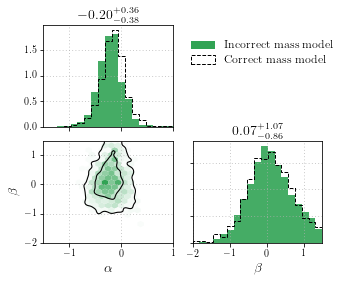

In [207]:
toPlot = {
    'a':{'data':injection_samps_plPeak[:,-2],'plot_bounds':(-1.5,1),'label':r'$\alpha$'},
    'b':{'data':injection_samps_plPeak[:,-1],'plot_bounds':(-2,1.5),'label':r'$\beta$'}
    }

fig = plt.figure(figsize=(5,4))
plot_corner(fig,toPlot,'#31a354',kernel=2.5,hist_alpha=0.9,lw=0)

ax = fig.axes[0]
ax.hist(injection_samps_bpl[:,-2],density=True,histtype='step',ls='--',color='black',bins=np.linspace(-1.5,1,20))

ax.legend([Rectangle((0,0),1,1,facecolor='#31a354'),Rectangle((0,0),1,1,facecolor='white',edgecolor='black',ls='--')],
                  ['Incorrect mass model','Correct mass model'],
                  fontsize=12,frameon=False,loc=(1.1,0.55),labelspacing=0.3)

ax = fig.axes[2]
ax.hist(injection_samps_bpl[:,-1],density=True,histtype='step',ls='--',color='black',bins=np.linspace(-2,1.5,20))

fig.subplots_adjust(wspace=0.15, hspace=0.14)
plt.savefig('./corner_injection_small.pdf',bbox_inches='tight')
plt.show()

In [269]:
from scipy.interpolate import interp2d

alphas_inj = injection_samps_plPeak[:,-2]
betas_inj = injection_samps_plPeak[:,-1]

xgrid = np.linspace(-1.5,1,100)
ygrid = np.linspace(-2,1.5,99)
dx = xgrid[1]-xgrid[0]
dy = ygrid[1]-ygrid[0]
heights,edgex,edgey = np.histogram2d(alphas_inj,betas_inj,bins=(xgrid,ygrid))
heights = gaussian_filter(heights,2.5)
heights /= np.sum(heights)*dx*dy

interpolator = interp2d((xgrid[1:] + xgrid[:-1])/2,(ygrid[1:] + ygrid[:-1])/2,heights.T)
height_at_origin = interpolator(0,0)[0]
heights_large_to_small = np.sort(heights.reshape(-1))[::-1]
cdf = np.cumsum(heights_large_to_small)*dx*dy
percentile_at_origin = 100.*np.interp(height_at_origin,heights_large_to_small[::-1],cdf[::-1])

with open('macros_pe_inj.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\injMean}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".format(*getBounds(injection_samps_plPeak[:,7])))
    macrofile.write("\n")
    macrofile.write("\\newcommand{{\\injSigma}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".format(*getBounds(10.**injection_samps_plPeak[:,8])))                
    macrofile.write("\n")
    macrofile.write("\\newcommand{{\\injQuantileAtOrigin}}{{{0:.0f}}}".format(percentile_at_origin))                
    macrofile.write("\n")
    
    
    
    
    #percentNegative = (100.*np.where(alphas<0)[0].size/alphas.size)
    #macrofile.write("\\newcommand{{\\percentAlphaNegative}}{{{0:.1f}\\%}}".format(percentNegative))    

# Negative effective spins

In [39]:
def fractionNegative(mu,sig,bound):
    numerator = erf((1.+mu)/(np.sqrt(2.)*sig)) + erf((bound-mu)/(np.sqrt(2.)*sig))
    denominator = erf((1.-mu)/(np.sqrt(2.)*sig)) + erf((1.+mu)/(np.sqrt(2.)*sig))
    return numerator/denominator

qs = np.linspace(0,1,100)
fneg = np.zeros((samps.shape[0],qs.size))

mu_at_q1 = np.zeros(samps.shape[0])
sig_at_q1 = np.zeros(samps.shape[0])

for i in range(samps.shape[0]):
    
    mu0 = samps[i,7]
    logsig0 = samps[i,8]
    alpha = samps[i,9]
    beta = samps[i,10]
    
    mu = mu0 + alpha*(qs-0.5)
    logsig = logsig0 + beta*(qs-0.5)
    fneg[i,:] = fractionNegative(mu,10**logsig,0)
    
    mu_at_q1[i] = mu0 + alpha*(1.-0.5)
    sig_at_q1[i] = 10.**(logsig0 + beta*(1.-0.5))

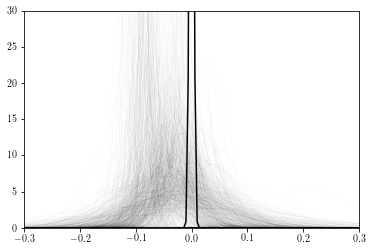

In [46]:
fig,ax = plt.subplots(figsize=(6,4))

chis = np.linspace(-1,1,500)
for i in range(samps.shape[0]):
    
    ax.plot(chis,calculate_Gaussian(chis,mu_at_q1[i],sig_at_q1[i]**2,-1,1),color='black',lw=0.1,alpha=0.1)

logsig_min = -1.5 + (-2)*(1.-0.5)
ax.plot(chis,calculate_Gaussian(chis,0,10.**(2.*logsig_min),-1,1),color='black')
    
ax.set_xlim(-0.3,0.3)
ax.set_ylim(0,30)
plt.show()

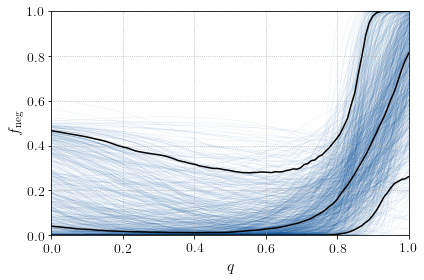

In [40]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)
for i in range(samps.shape[0]):
    
    ax.plot(qs,fneg[i,:],color='#08519c',alpha=0.2,lw=0.2,zorder=-2)
    
ax.plot(qs,np.quantile(fneg,0.05,axis=0),color='black')
ax.plot(qs,np.quantile(fneg,0.5,axis=0),color='black')
ax.plot(qs,np.quantile(fneg,0.95,axis=0),color='black')

ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel(r"$q$",fontsize=16)
ax.set_ylabel(r"$f_\mathrm{neg}$",fontsize=16)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

plt.tight_layout()
plt.savefig('f_neg.pdf',bbox_inches='tight')
plt.show()

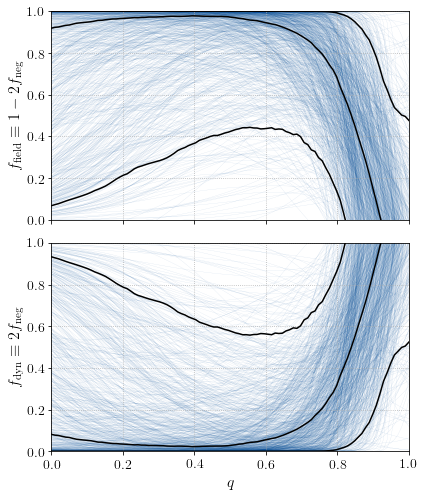

In [55]:
fig = plt.figure(figsize=(6,7))

ax = fig.add_subplot(211)
for i in range(samps.shape[0]):
    
    ax.plot(qs,1.-2.*fneg[i,:],color='#08519c',alpha=0.2,lw=0.2,zorder=-2)
    
ax.plot(qs,np.quantile(1.-2.*fneg,0.05,axis=0),color='black')
ax.plot(qs,np.quantile(1.-2.*fneg,0.5,axis=0),color='black')
ax.plot(qs,np.quantile(1.-2.*fneg,0.95,axis=0),color='black')

ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.set_xticklabels([])
ax.tick_params(labelsize=14)
ax.set_ylabel(r"$f_\mathrm{field} \equiv 1-2f_\mathrm{neg}$",fontsize=16)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax = fig.add_subplot(212)
for i in range(samps.shape[0]):
    
    ax.plot(qs,2.*fneg[i,:],color='#08519c',alpha=0.2,lw=0.2,zorder=-2)

ax.plot(qs,np.quantile(2.*fneg,0.05,axis=0),color='black')
ax.plot(qs,np.quantile(2.*fneg,0.5,axis=0),color='black')
ax.plot(qs,np.quantile(2.*fneg,0.95,axis=0),color='black')   
    
ax.xaxis.grid(True,which='major',ls=':')
ax.yaxis.grid(True,which='major',ls=':')
ax.set_axisbelow(True)
ax.tick_params(labelsize=14)
ax.set_xlabel(r"$q$",fontsize=16)
ax.set_ylabel(r"$f_\mathrm{dyn}\equiv 2 f_\mathrm{neg}$",fontsize=16)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

plt.tight_layout()
plt.savefig('f_dyn_iso.pdf',bbox_inches='tight')
plt.show()

# Bayes factors

In [271]:
logz_noEvol_noNeg = np.array([])
fs = glob.glob("../dynesty_output/dynesty_results_noEvol_noNeg_job?.npy")
for f in fs:
    logz_noEvol_noNeg = np.append(logz_noEvol_noNeg,np.load(f,allow_pickle=True)[()]['logz'][-1])

print(np.mean(logz_noEvol_noNeg),np.std(logz_noEvol_noNeg))

logz_noEvol = np.array([])
fs = glob.glob("../dynesty_output/dynesty_results_noEvol_job?.npy")
for f in fs:
    logz_noEvol = np.append(logz_noEvol,np.load(f,allow_pickle=True)[()]['logz'][-1])

print(np.mean(logz_noEvol),np.std(logz_noEvol))

logz_evol_noNeg = np.array([])
fs = glob.glob("../dynesty_output/dynesty_results_noNeg_job?.npy")
for f in fs:
    logz_evol_noNeg = np.append(logz_evol_noNeg,np.load(f,allow_pickle=True)[()]['logz'][-1])

print(np.mean(logz_evol_noNeg),np.std(logz_evol_noNeg))

logz_evol = np.array([])
fs = glob.glob("../dynesty_output/dynesty_results_job?.npy")
for f in fs:
    logz_evol = np.append(logz_evol,np.load(f,allow_pickle=True)[()]['logz'][-1])

print(np.mean(logz_evol),np.std(logz_evol))

-908.7939800856495 0.03588128316132262
-907.5065730365966 0.03932568381336693
-905.2526470736726 0.02764047318157412
-905.1562703279045 0.028298529381597416


In [283]:
def getBayes(logzs_A,logzs_B):
    
    bayes = logzs_A-np.mean(logzs_B)
    return np.mean(bayes), np.std(bayes)

In [284]:
print(getBayes(logz_noEvol,logz_noEvol_noNeg))
print(getBayes(logz_evol_noNeg,logz_noEvol_noNeg))
print(getBayes(logz_evol,logz_noEvol_noNeg))
print(getBayes(logz_evol,logz_evol_noNeg))

(1.287407049052956, 0.03932568381336693)
(3.5413330119768602, 0.027640473181574123)
(3.6377097577449375, 0.028298529381597413)
(0.09637674576802055, 0.028298529381597413)


In [296]:
with open('macros_bayes.txt','w') as macrofile:
    
    mean,std = getBayes(logz_noEvol_noNeg,logz_noEvol_noNeg)
    macrofile.write("\\newcommand{{\\evidenceNoEvolNoNeg}}{{{0:.2f}}}".format(mean))
    macrofile.write("\n")
    macrofile.write("\\newcommand{{\\evidenceNoEvolNoNegError}}{{{0:.2f}}}".format(std))
    macrofile.write("\n")
    
    mean,std = getBayes(logz_noEvol,logz_noEvol_noNeg)
    macrofile.write("\\newcommand{{\\evidenceNoEvolYesNeg}}{{{0:.2f}}}".format(mean))
    macrofile.write("\n")
    macrofile.write("\\newcommand{{\\evidenceNoEvolYesNegError}}{{{0:.2f}}}".format(std))
    macrofile.write("\n")
    
    mean,std = getBayes(logz_evol_noNeg,logz_noEvol_noNeg)
    macrofile.write("\\newcommand{{\\evidenceYesEvolNoNeg}}{{{0:.2f}}}".format(mean))
    macrofile.write("\n")
    macrofile.write("\\newcommand{{\\evidenceYesEvolNoNegError}}{{{0:.2f}}}".format(std))
    macrofile.write("\n")
    
    mean,std = getBayes(logz_evol,logz_noEvol_noNeg)
    macrofile.write("\\newcommand{{\\evidenceYesEvolYesNeg}}{{{0:.2f}}}".format(mean))
    macrofile.write("\n")
    macrofile.write("\\newcommand{{\\evidenceYesEvolYesNegError}}{{{0:.2f}}}".format(std))
    macrofile.write("\n")
    
    mean,std = getBayes(logz_evol,logz_evol_noNeg)
    macrofile.write("\\newcommand{{\\bayesNegWhenCorrelated}}{{{0:.2f}}}".format(mean))
    macrofile.write("\n")
